In [5]:
import seaborn as sns
import matplotlib as plt

%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

In [2]:
import rasterio
import numpy as np

tif_path = "./test_saved/ROIs1158_spring_1_p100_pred.tif"

with rasterio.open(tif_path) as src:
    num_channels = src.count
    print("Количество каналов:", num_channels)
    
    img = src.read()
    
    print("NumPy shape (C, H, W):", img.shape)
    
    channel_names = ['B1 (cb)', 'B2 (blue)', 'B3 (green)', 'B4 (red)', 'B5 (re1)', 
                     'B6 (re2)', 'B7 (re3)', 'B8 (nir)', 'B8A (nir2)', 'B9 (waterVapor)', 
                     'B10 (cirrus)', 'B11 (swir1)', 'B12 (swir2)']
    
    if src.descriptions:
        channel_names = list(src.descriptions) if any(src.descriptions) else channel_names

    print("\nСопоставление индексов:")
    print(f"{'Rasterio (1-based)':<20} {'NumPy (0-based)':<20} {'Название канала':<20}")
    print("=" * 60)

    for i in range(num_channels):
        rasterio_idx = i + 1  # 1-based
        numpy_idx = i  # 0-based
        channel_name = channel_names[i] if i < len(channel_names) else f"Канал {rasterio_idx}"
        print(f"{rasterio_idx:<20} {numpy_idx:<20} {channel_name:<20}")

        # Вывод статистики
        print(f"Min: {img[numpy_idx].min():.4f}, Max: {img[numpy_idx].max():.4f}, Mean: {img[numpy_idx].mean():.4f}\n")

Количество каналов: 13
NumPy shape (C, H, W): (13, 256, 256)

Сопоставление индексов:
Rasterio (1-based)   NumPy (0-based)      Название канала     
1                    0                    B1 (cb)             
Min: 0.0599, Max: 0.1963, Mean: 0.1345

2                    1                    B2 (blue)           
Min: 0.0453, Max: 0.1976, Mean: 0.1106

3                    2                    B3 (green)          
Min: 0.0657, Max: 0.2193, Mean: 0.1112

4                    3                    B4 (red)            
Min: 0.0351, Max: 0.2615, Mean: 0.1006

5                    4                    B5 (re1)            
Min: 0.0614, Max: 0.2644, Mean: 0.1358

6                    5                    B6 (re2)            
Min: 0.1634, Max: 0.3279, Mean: 0.2450

7                    6                    B7 (re3)            
Min: 0.2140, Max: 0.3807, Mean: 0.2965

8                    7                    B8 (nir)            
Min: 0.1679, Max: 0.3950, Mean: 0.2781

9                    8     

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

import torch

In [7]:
import os
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def read_tiff(path):
    with rasterio.open(path) as src:
        data = src.read()
    return torch.tensor(data, dtype=torch.float32)

def compute_SAM(gt, pred):
    eps = 1e-8
    gt_flat = gt.view(gt.size(0), -1)
    pred_flat = pred.view(pred.size(0), -1)

    dot_product = torch.sum(gt_flat * pred_flat, dim=0)
    norm_gt = torch.norm(gt_flat, dim=0) + eps
    norm_pred = torch.norm(pred_flat, dim=0) + eps

    cos_theta = dot_product / (norm_gt * norm_pred)
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    angles = torch.acos(cos_theta)
    return torch.mean(angles).item()

def get_index(index_name, img):
    """
    index_name: название индекса (NDWI, NDMI, NDVI, SR, REP, EVI, EVI2, ARVI, SAVI, GOSAVI, GARI, VARI)
    img: тензор формы (13, H, W), где:
         img[0]  = B1 (coastal),
         img[1]  = B2 (blue),
         img[2]  = B3 (green),
         img[3]  = B4 (red),
         img[4]  = B5 (redEdge1),
         img[5]  = B6 (redEdge2),
         img[6]  = B7 (redEdge3),
         img[7]  = B8 (NIR),
         img[8]  = B8A (NIR narrow),
         img[9]  = B9  (water vapor),
         img[10] = B10 (cirrus),
         img[11] = B11 (SWIR1),
         img[12] = B12 (SWIR2).
    """
    eps = 1e-8

    if index_name == "NDWI":
        # Green = B3 = img[2], NIR = B8 = img[7]
        green = img[2, :, :]
        nir   = img[7, :, :]
        return (green - nir) / (green + nir + eps)

    elif index_name == "NDMI":
        # NIR = B8 = img[7], SWIR1 = B11 = img[11]
        nir   = img[7, :, :]
        swir1 = img[11, :, :]
        return (nir - swir1) / (nir + swir1 + eps)

    elif index_name == "NDVI":
        # Red = B4 = img[3], NIR = B8 = img[7]
        red = img[3, :, :]
        nir = img[7, :, :]
        return (nir - red) / (nir + red + eps)

    elif index_name == "SR":  
        # Simple ratio = NIR/Red
        nir = img[7, :, :]
        red = img[3, :, :]
        return nir / (red + eps)

    elif index_name == "REP":
        # RedEdge Position
        # B4=img[3], B5=img[4], B6=img[5], B7=img[6]
        b4 = img[3, :, :]
        b5 = img[4, :, :]
        b6 = img[5, :, :]
        b7 = img[6, :, :]
        numerator = ((b7 + b4) / 2) - b5
        denominator = (b6 - b5) + eps
        return 700 + 40 * (numerator / denominator)

    elif index_name == "EVI":
        # EVI = 2.5 * (NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1)
        nir  = img[7, :, :]
        red  = img[3, :, :]
        blue = img[1, :, :]
        return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0 + eps)

    elif index_name == "EVI2":
        # EVI2 = 2.5 * (NIR - RED) / (NIR + RED + 1)
        nir = img[7, :, :]
        red = img[3, :, :]
        return 2.5 * (nir - red) / (nir + red + 1.0 + eps)

    elif index_name == "ARVI":
        # ARVI = (NIR - (2*RED - BLUE)) / (NIR + (2*RED - BLUE))
        nir  = img[7, :, :]
        red  = img[3, :, :]
        blue = img[1, :, :]
        return (nir - (2*red - blue)) / (nir + (2*red - blue) + eps)

    elif index_name == "SAVI":
        # SAVI = 1.5 * (NIR - RED) / (NIR + RED + 0.5)
        nir = img[7, :, :]
        red = img[3, :, :]
        return 1.5 * (nir - red) / (nir + red + 0.5 + eps)

    elif index_name == "GOSAVI":
        # Green = B3 = img[2], NIR = B8 = img[7]
        nir   = img[7, :, :]
        green = img[2, :, :]
        return (nir - green) / (nir + green + 0.16 + eps)

    elif index_name == "GARI":
        # GARI = (NIR - (GREEN - (BLUE - RED))) / (NIR + (GREEN - (BLUE - RED)))
        nir   = img[7, :, :]
        red   = img[3, :, :]
        green = img[2, :, :]
        blue  = img[1, :, :]
        return (nir - (green - (blue - red))) / (nir + (green - (blue - red)) + eps)

    elif index_name == "VARI":
        # VARI = (GREEN - RED) / (GREEN + RED - BLUE)
        red   = img[3, :, :]
        green = img[2, :, :]
        blue  = img[1, :, :]
        return (green - red) / (green + red - blue + eps)

    else:
        raise ValueError(f"Индекс {index_name} не поддерживается.")

def plot_channel_histograms(gt_tensors, pred_tensors, channel_idx=4):
    all_gt_vals = []
    all_pred_vals = []
    for gt_data, pred_data in zip(gt_tensors, pred_tensors):
        channel_gt = gt_data[channel_idx].numpy().flatten()
        channel_pred = pred_data[channel_idx].numpy().flatten()
        all_gt_vals.append(channel_gt)
        all_pred_vals.append(channel_pred)
    all_gt_vals = np.concatenate(all_gt_vals)
    all_pred_vals = np.concatenate(all_pred_vals)

    plt.figure(figsize=(8,4))
    plt.hist(all_gt_vals, bins=100, alpha=0.5, label='GT')
    plt.hist(all_pred_vals, bins=100, alpha=0.5, label='Pred')
    plt.title(f'Гистограмма канала {channel_idx}')
    plt.xlabel('Значение')
    plt.ylabel('Количество пикселей')
    plt.legend()
    plt.show()

def get_min_max_per_channel(tensor_list, channel_idx):
    cmin, cmax = float('inf'), -float('inf')
    for t in tensor_list:
        arr = t[channel_idx].numpy()
        mn, mx = arr.min(), arr.max()
        if mn < cmin:
            cmin = mn
        if mx > cmax:
            cmax = mx
    return cmin, cmax

Using device: cpu


In [8]:
test_saved_dir = "./test_saved"
gt_files = sorted([f for f in os.listdir(test_saved_dir) if f.endswith("_GT.tif")])

indices = ["NDWI", "NDMI", "NDVI", "SR", "REP", "EVI", "EVI2",
           "ARVI", "SAVI", "GOSAVI", "GARI", "VARI"]

gt_data_list = []
pred_data_list = []
cloudy_data_list = []

sam_values = []
channel_means_gt_list = []
channel_means_pred_list = []
channel_means_cloudy_list = []


index_means_list = []

def process_file_triplet(f_gt):
    base_name = f_gt.replace("_GT.tif", "")
    f_pred = base_name + "_pred.tif"
    f_cloudy = base_name + "_cloudy.tif"

    path_gt = os.path.join(test_saved_dir, f_gt)
    path_pred = os.path.join(test_saved_dir, f_pred)
    path_cloudy = os.path.join(test_saved_dir, f_cloudy)

    if not os.path.exists(path_pred):
        return None

    if not os.path.exists(path_cloudy):
        return None

    gt_data_gpu = read_tiff(path_gt).to(device)       # (C,H,W)
    pred_data_gpu = read_tiff(path_pred).to(device)   # (C,H,W)
    cloudy_data_gpu = read_tiff(path_cloudy).to(device)  # (C,H,W)

    sam_val = compute_SAM(gt_data_gpu, pred_data_gpu)

    mean_gt    = torch.mean(gt_data_gpu, dim=(1,2)).cpu().numpy()     # (C,)
    mean_pred  = torch.mean(pred_data_gpu, dim=(1,2)).cpu().numpy()   # (C,)
    mean_cloudy= torch.mean(cloudy_data_gpu, dim=(1,2)).cpu().numpy() # (C,)

    mean_idx_vals = {}
    for idx_name in indices:
        gt_idx = get_index(idx_name, gt_data_gpu)
        pred_idx = get_index(idx_name, pred_data_gpu)
        cloudy_idx = get_index(idx_name, cloudy_data_gpu)

        mean_idx_vals[idx_name] = (
            gt_idx.mean().item(),
            pred_idx.mean().item(),
            cloudy_idx.mean().item()
        )

    gt_data_cpu = gt_data_gpu.cpu()
    pred_data_cpu = pred_data_gpu.cpu()
    cloudy_data_cpu = cloudy_data_gpu.cpu()

    return (sam_val, mean_gt, mean_pred, mean_cloudy, 
            mean_idx_vals, gt_data_cpu, pred_data_cpu, cloudy_data_cpu)

from concurrent.futures import ThreadPoolExecutor, as_completed

results = []
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(process_file_triplet, f_gt) for f_gt in gt_files]
    for fut in as_completed(futures):
        res = fut.result()
        if res is not None:
            results.append(res)

for r in results:
    (sam_val, mean_gt, mean_pred, mean_cloudy, 
     mean_idx_vals, gt_data_cpu, pred_data_cpu, cloudy_data_cpu) = r

    sam_values.append(sam_val)

    channel_means_gt_list.append(mean_gt)
    channel_means_pred_list.append(mean_pred)
    channel_means_cloudy_list.append(mean_cloudy)

    index_means_list.append(mean_idx_vals)

    gt_data_list.append(gt_data_cpu)
    pred_data_list.append(pred_data_cpu)
    cloudy_data_list.append(cloudy_data_cpu)

print(f"Готово. Обработано тройных TIFF: {len(results)}")

/opt/conda/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Готово. Обработано тройных TIFF: 12222


Средний SAM (GT vs Pred): 0.0597

Средние значения индексов (GT / Pred / Cloudy):
NDWI: GT=-0.2908, Pred=-0.2936, Cloudy=-0.1883
NDMI: GT=0.0902, Pred=0.0872, Cloudy=0.1211
NDVI: GT=0.3364, Pred=0.3398, Cloudy=0.2187
SR: GT=11.3483, Pred=2.6976, Cloudy=2.0806
REP: GT=2176.5580, Pred=719.7678, Cloudy=-17261.3185
EVI: GT=0.3383, Pred=0.2918, Cloudy=5.4360
EVI2: GT=0.2083, Pred=0.2088, Cloudy=0.1564
ARVI: GT=397.3451, Pred=0.4525, Cloudy=351.5348
SAVI: GT=0.2000, Pred=0.2010, Cloudy=0.1447
GOSAVI: GT=0.2050, Pred=0.2061, Cloudy=0.1410
GARI: GT=116.2840, Pred=0.4446, Cloudy=26.6089
VARI: GT=466.8073, Pred=0.3493, Cloudy=418.5536


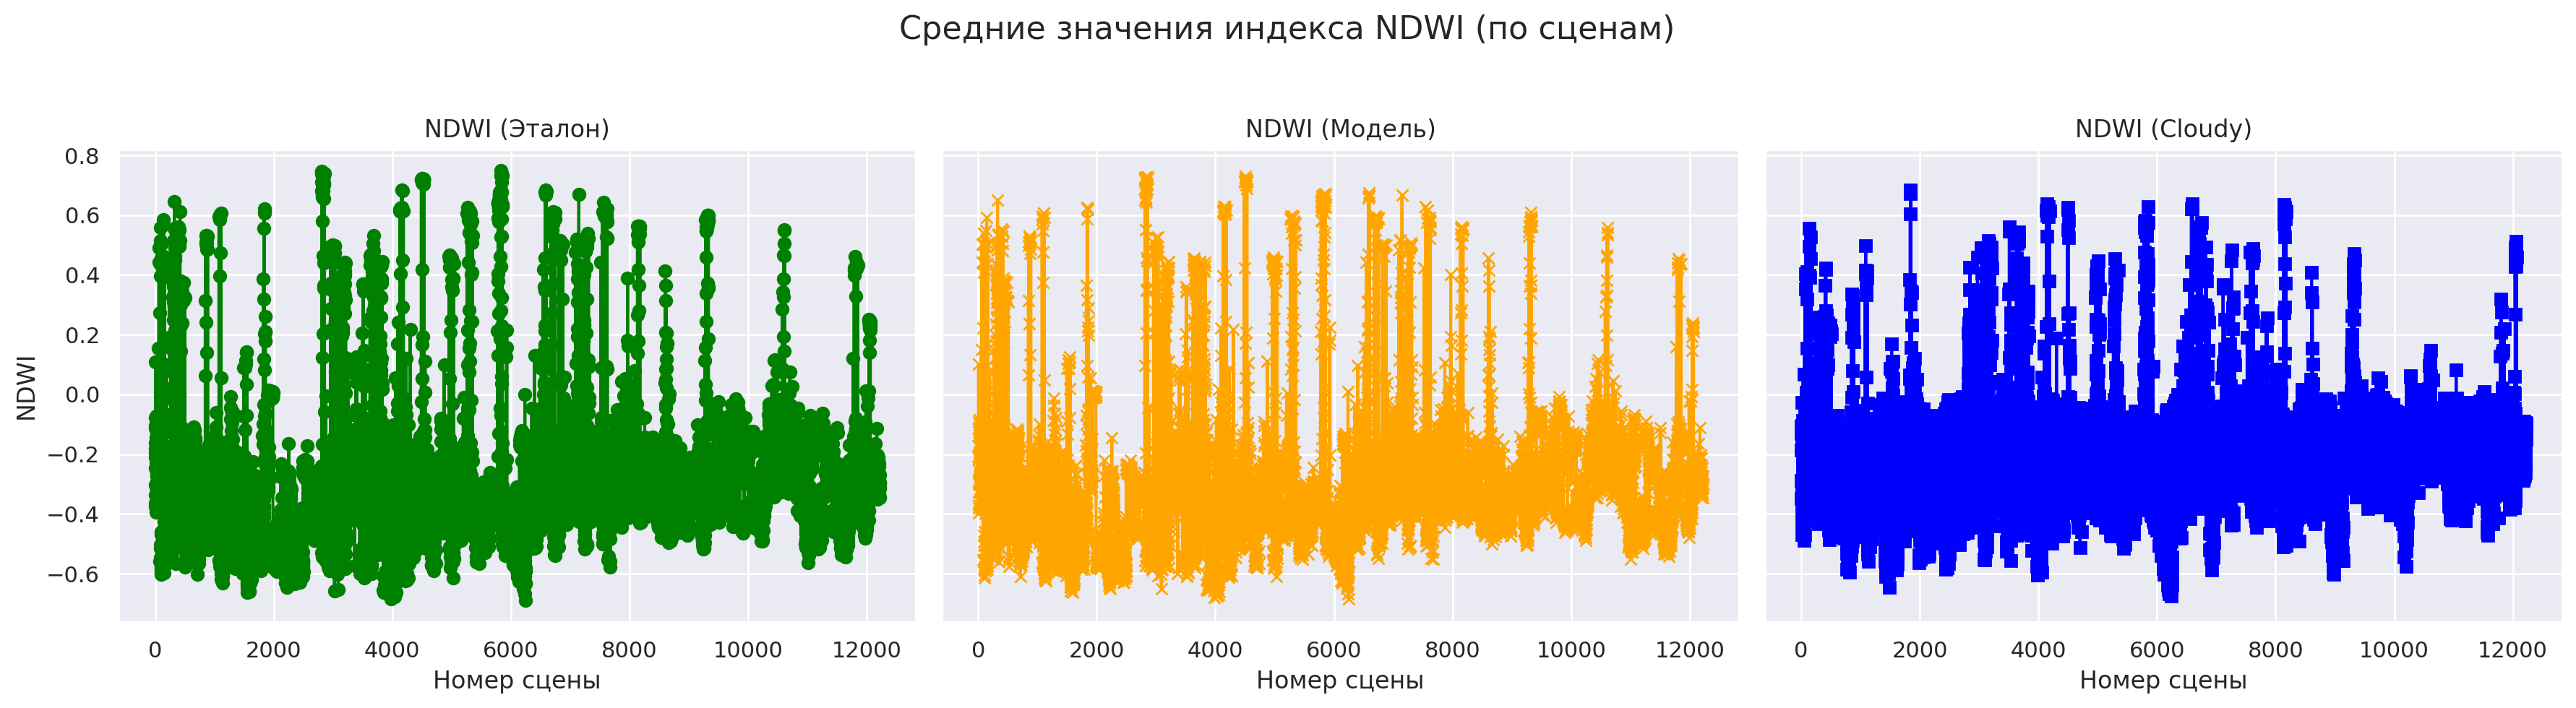

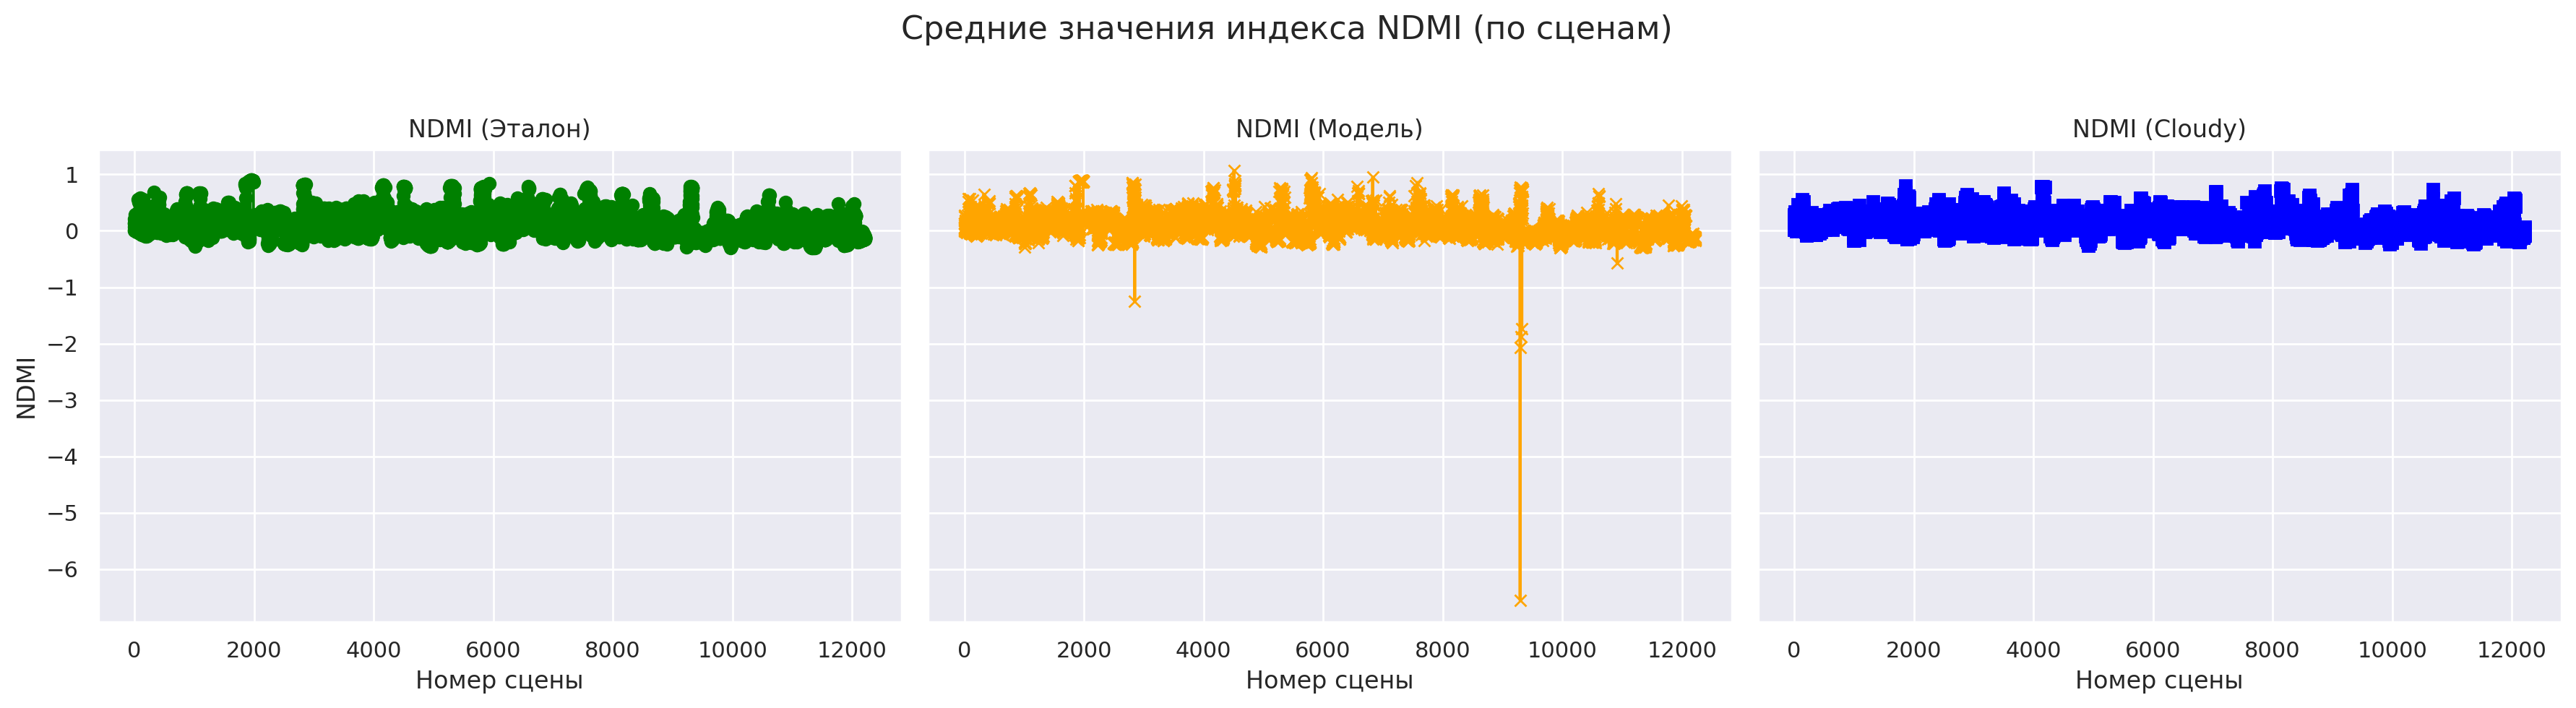

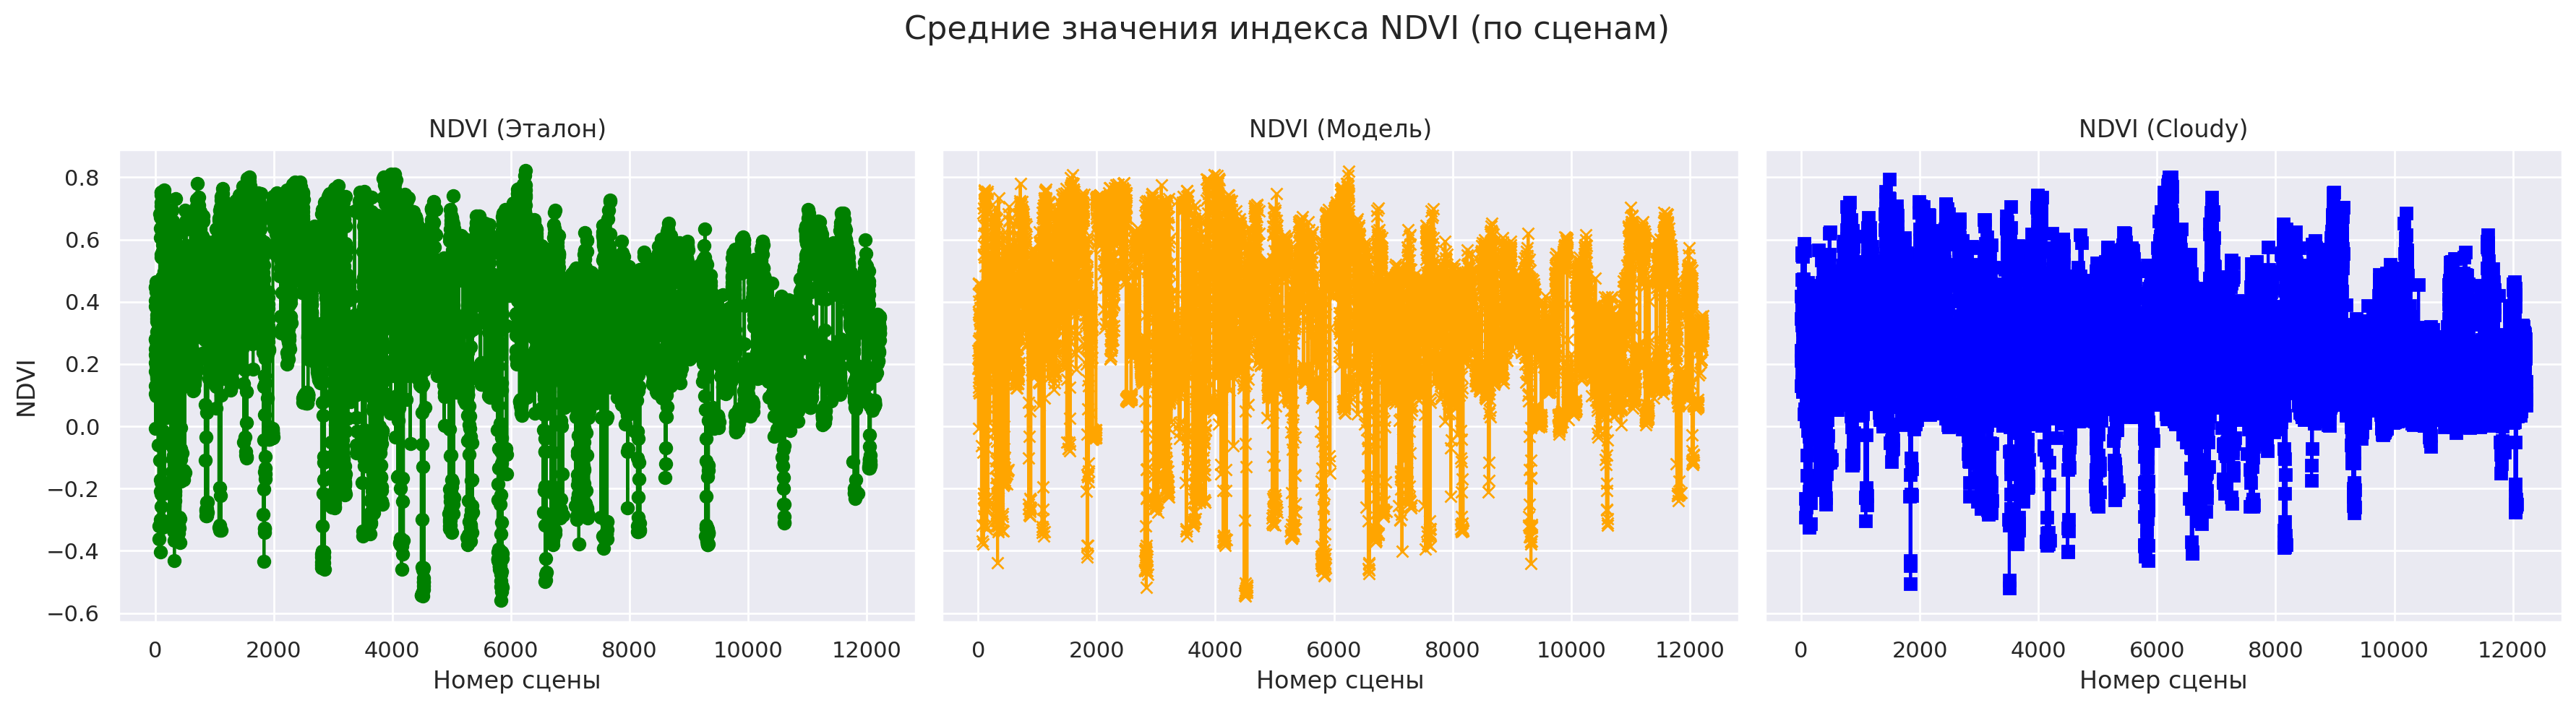

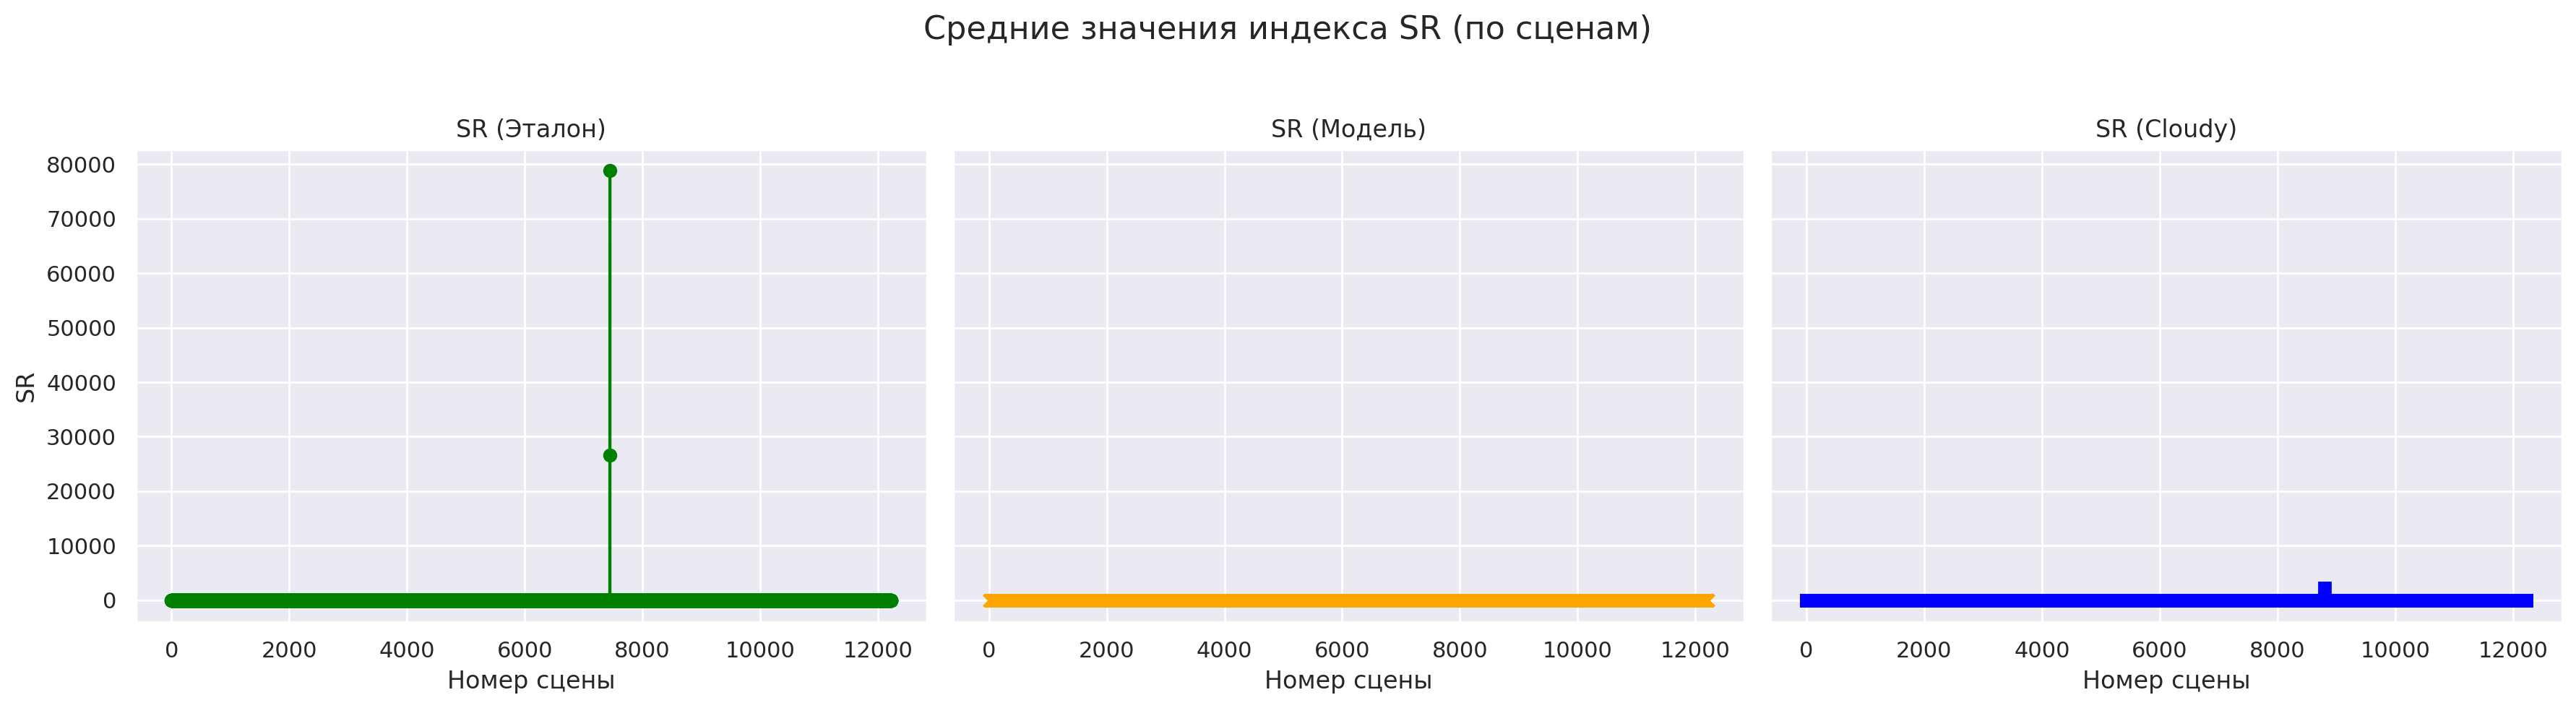

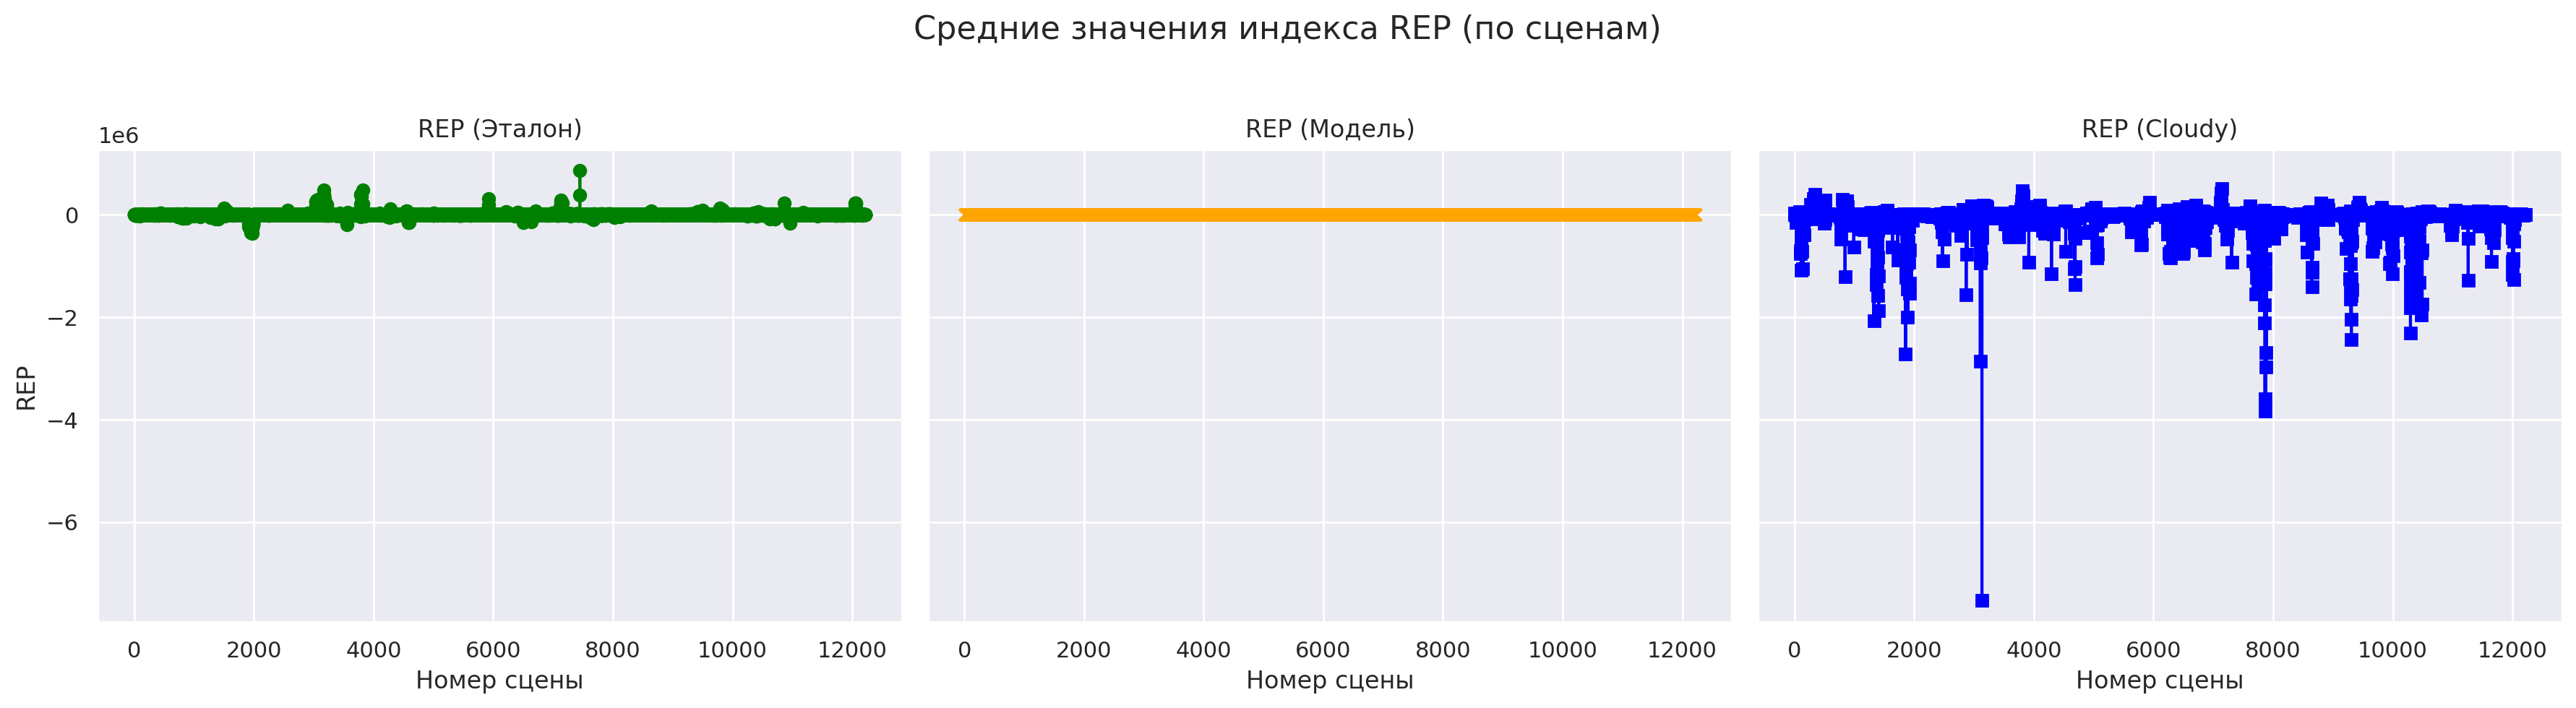

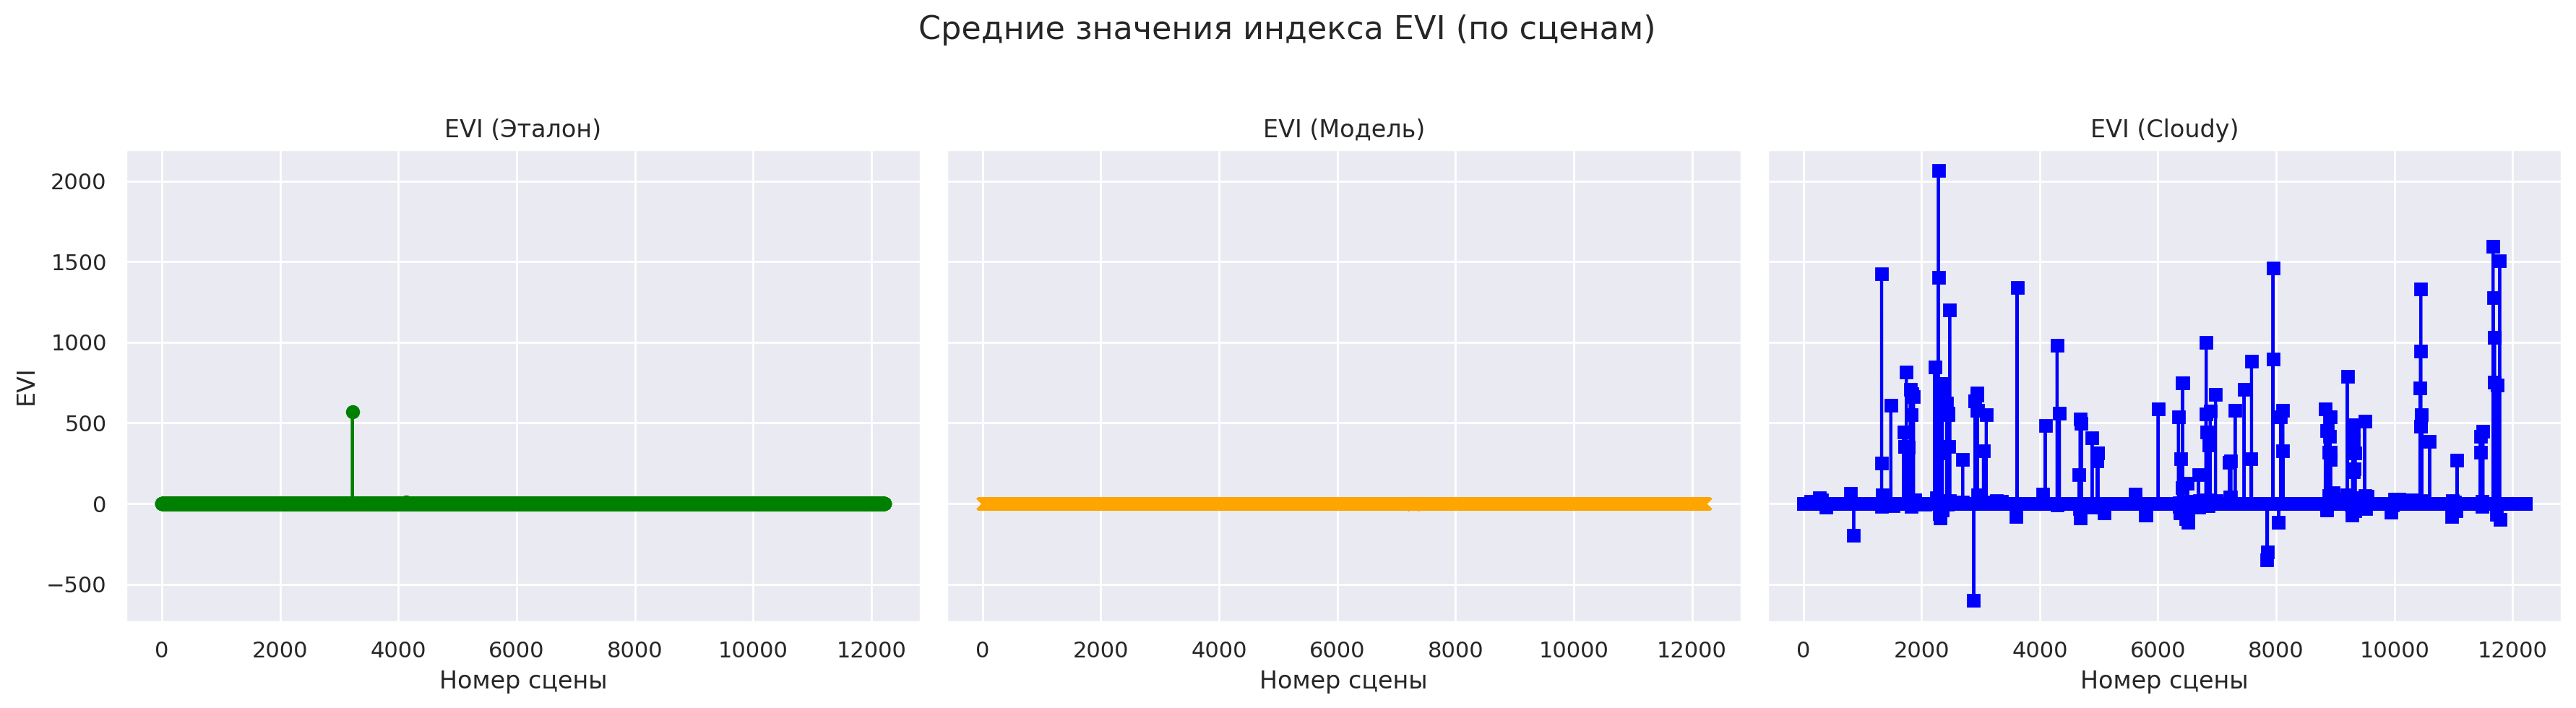

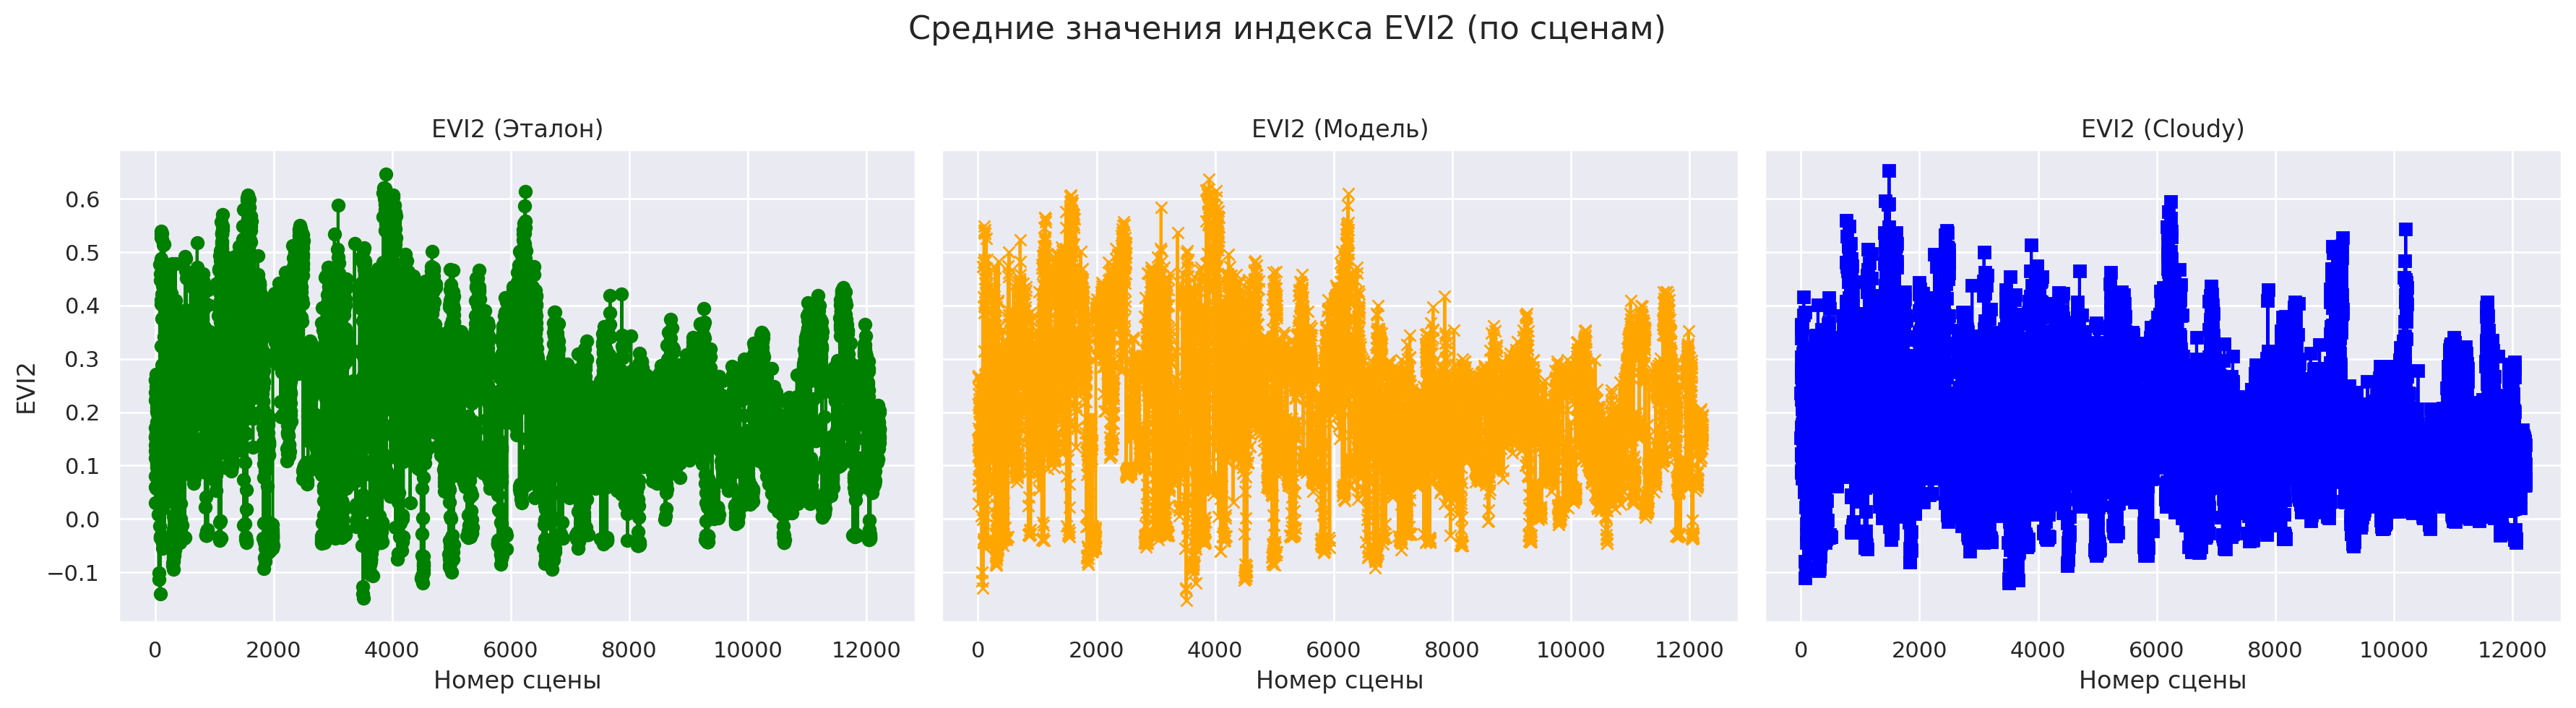

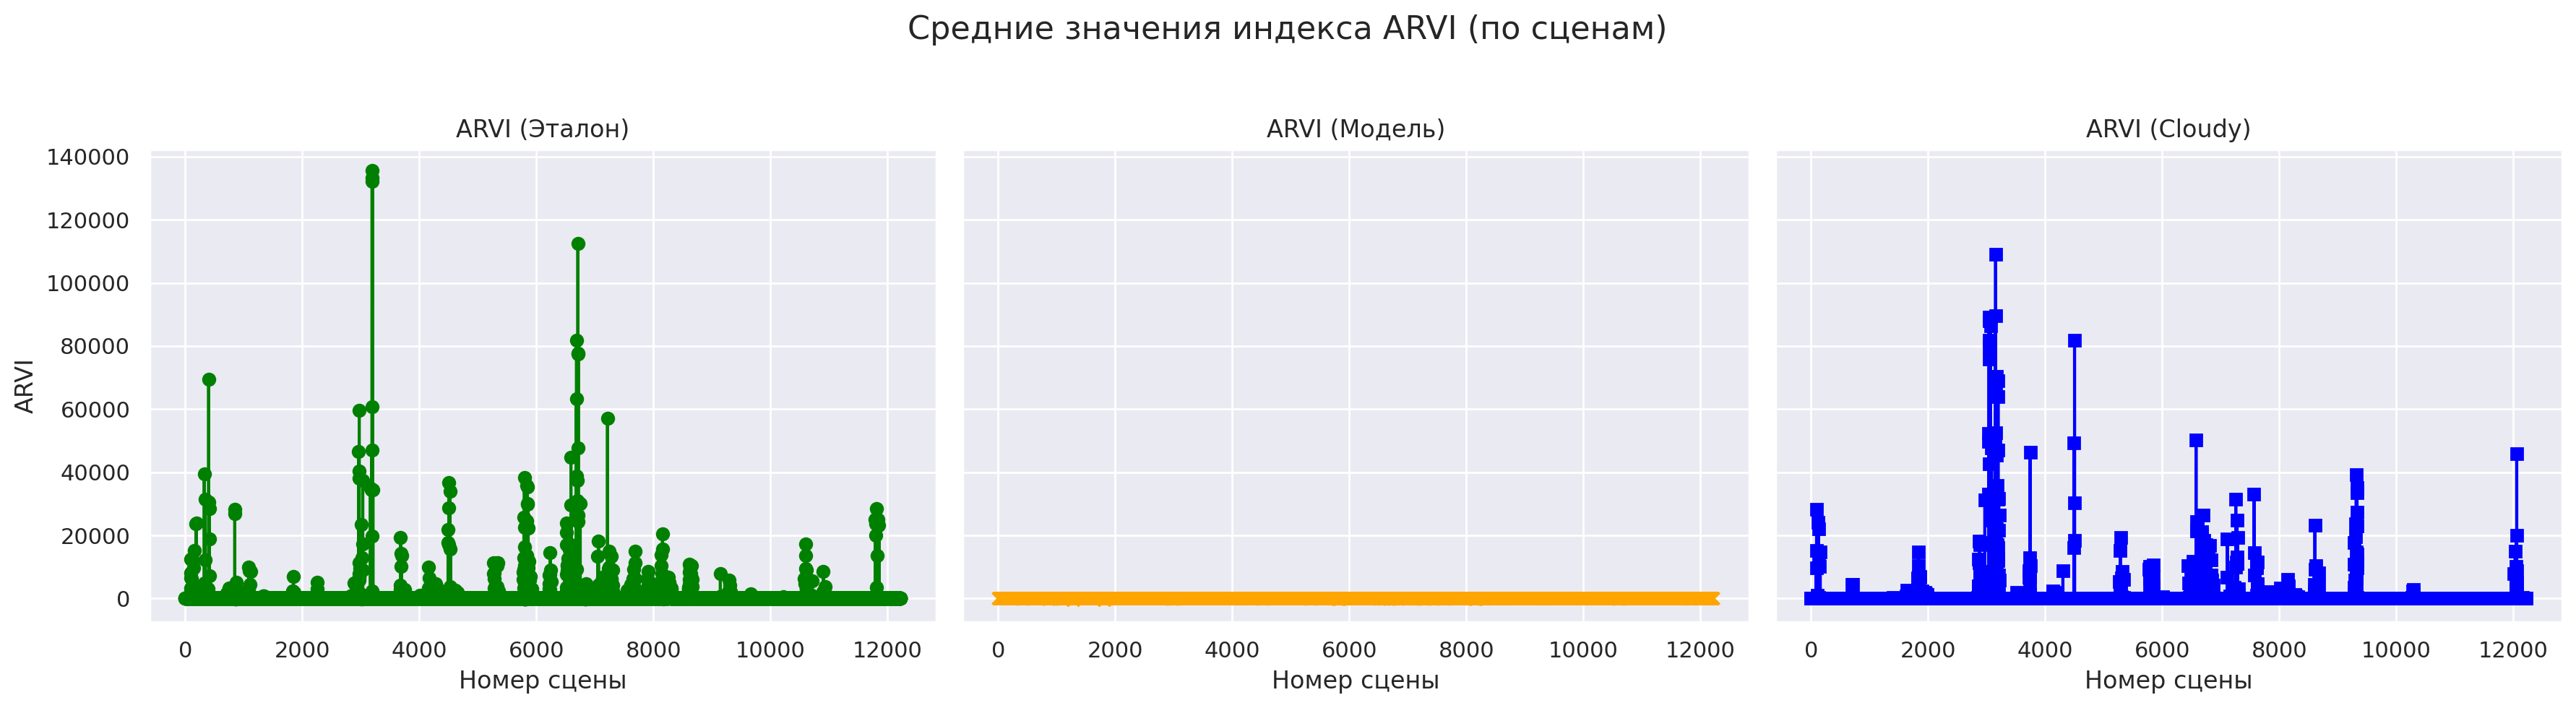

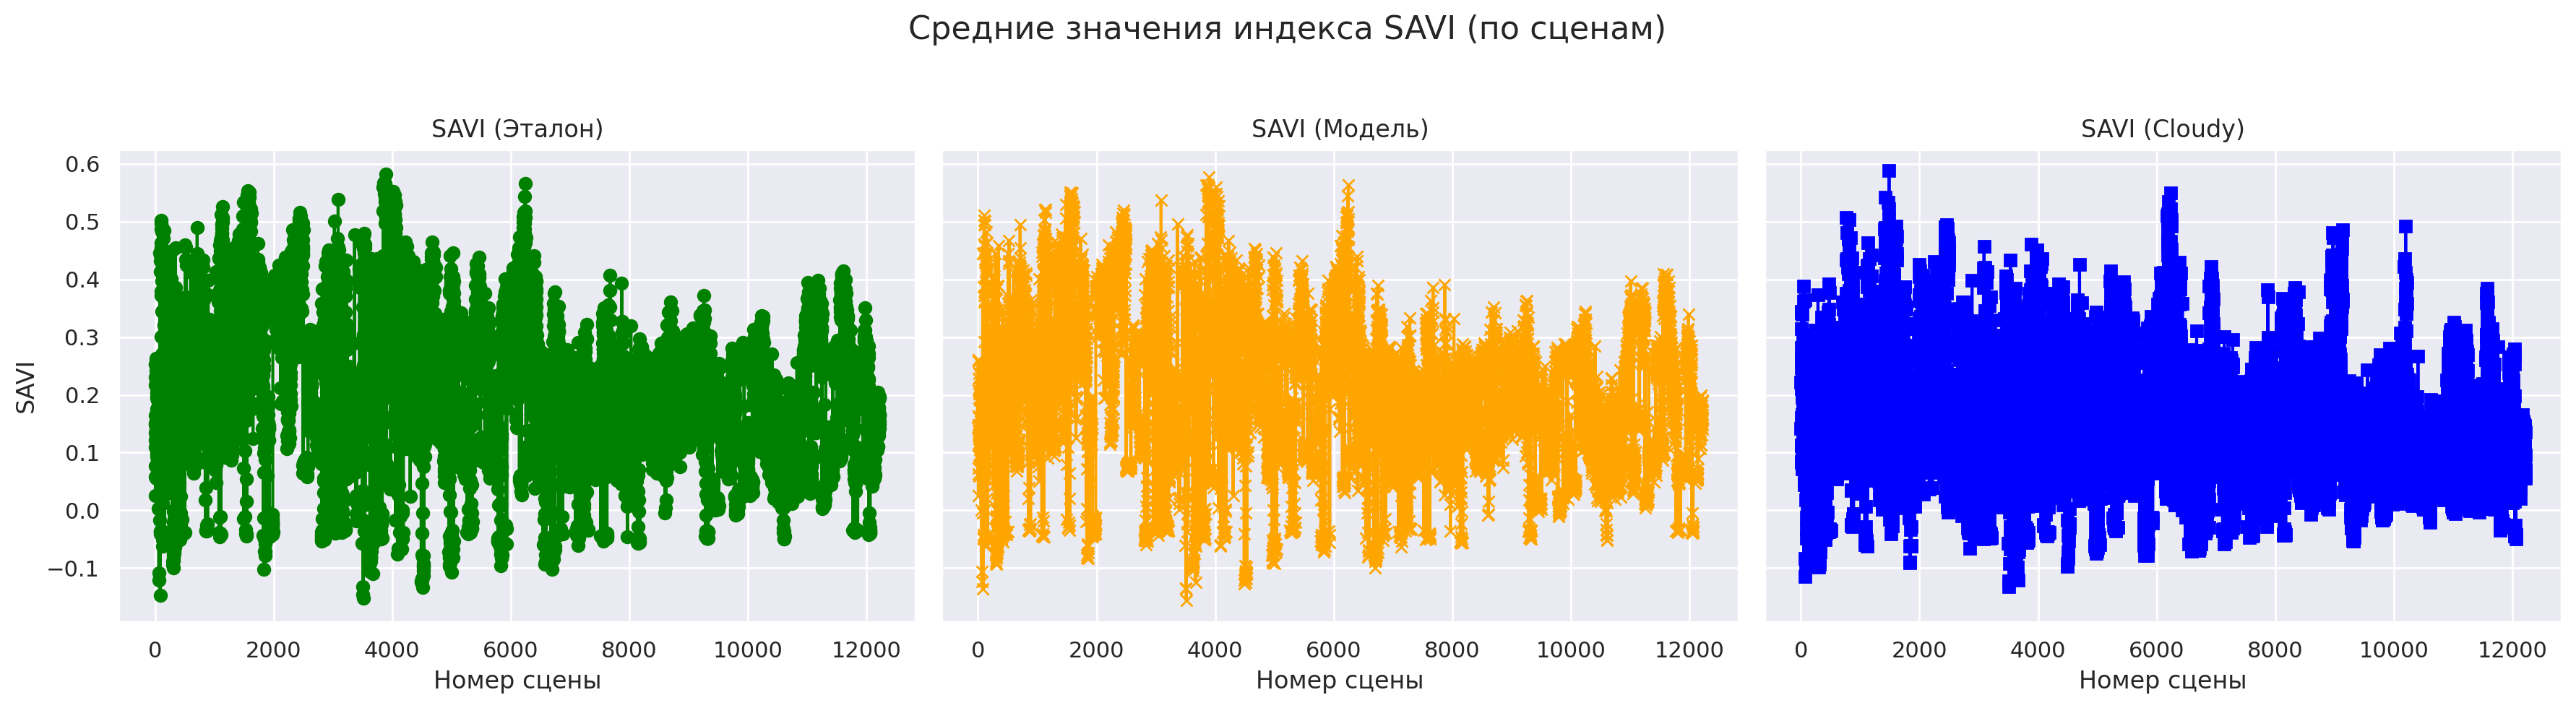

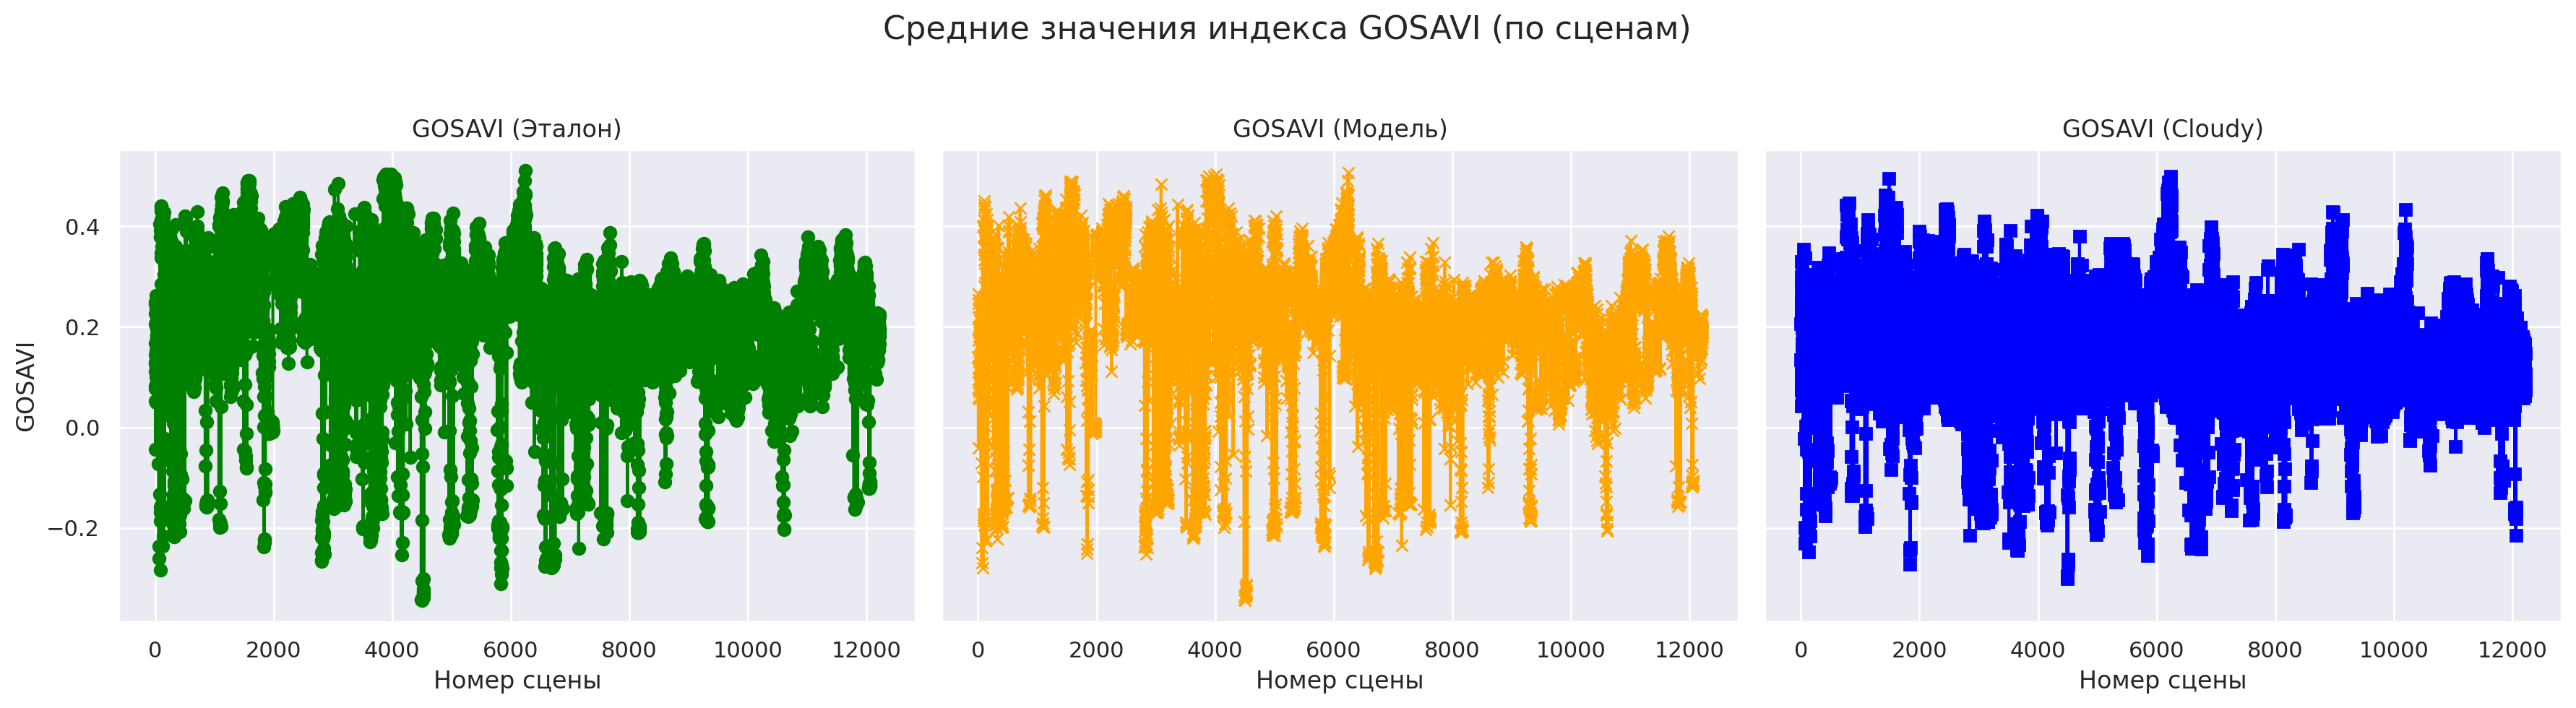

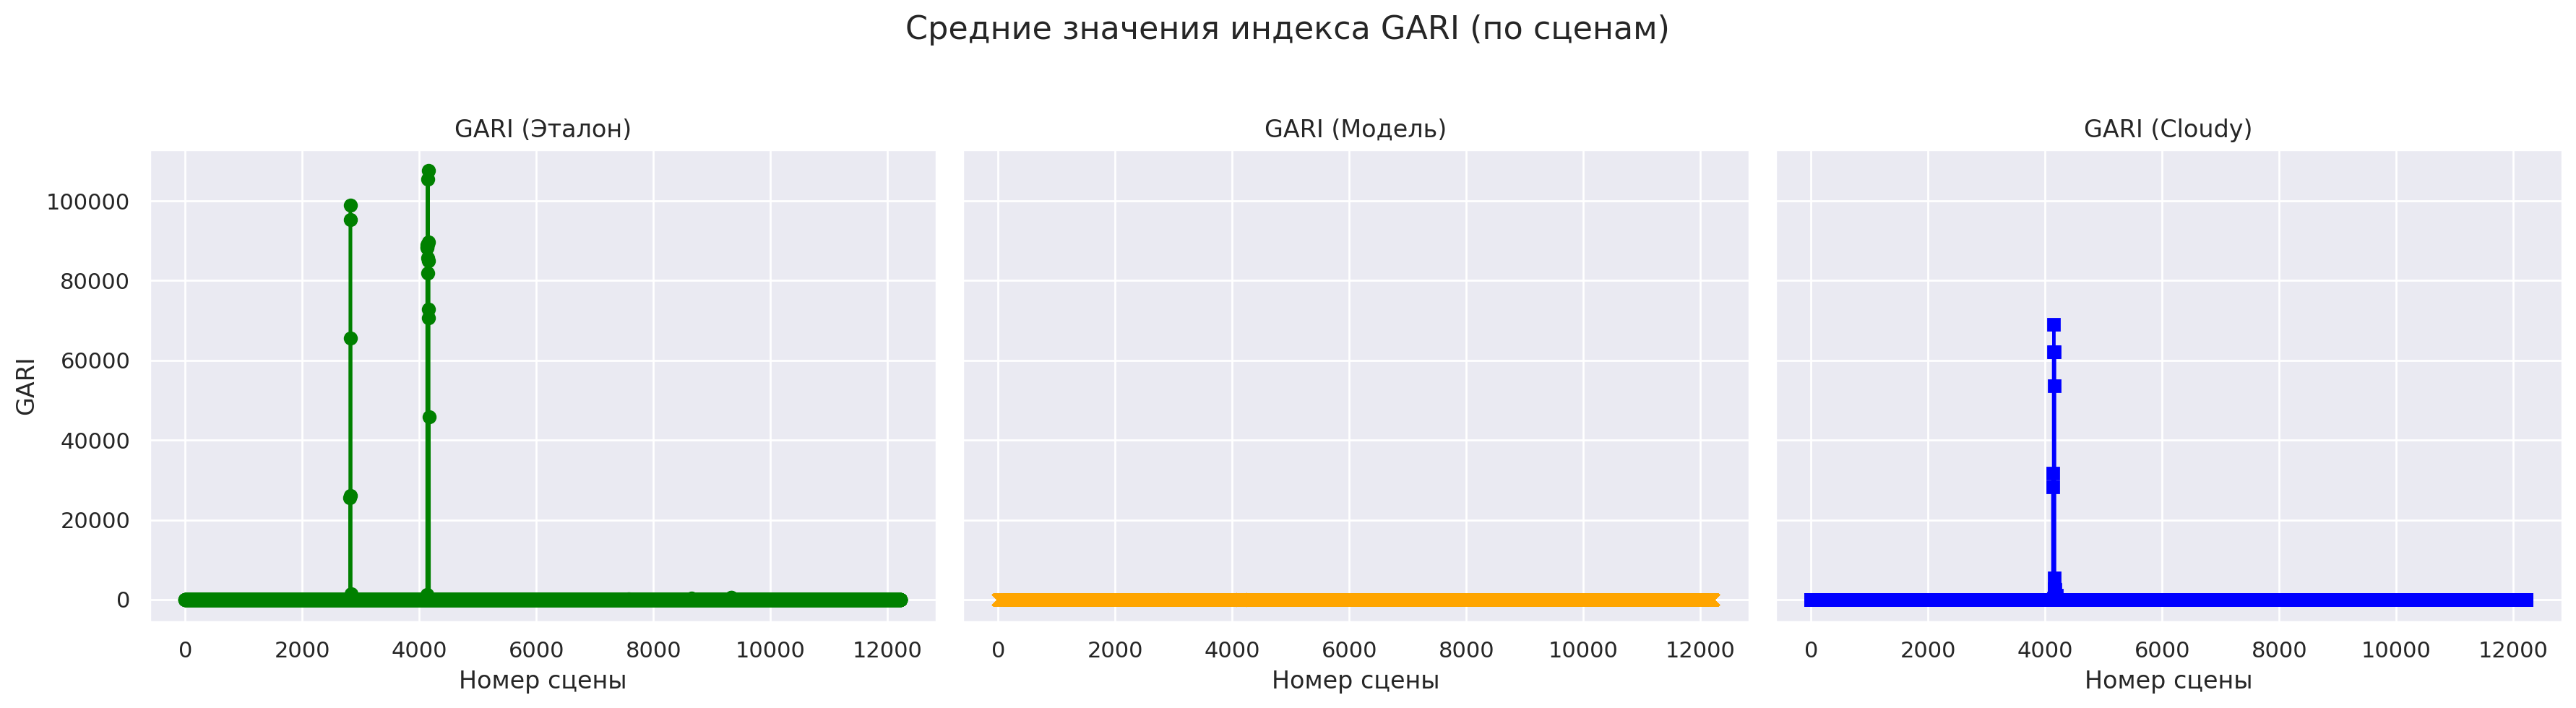

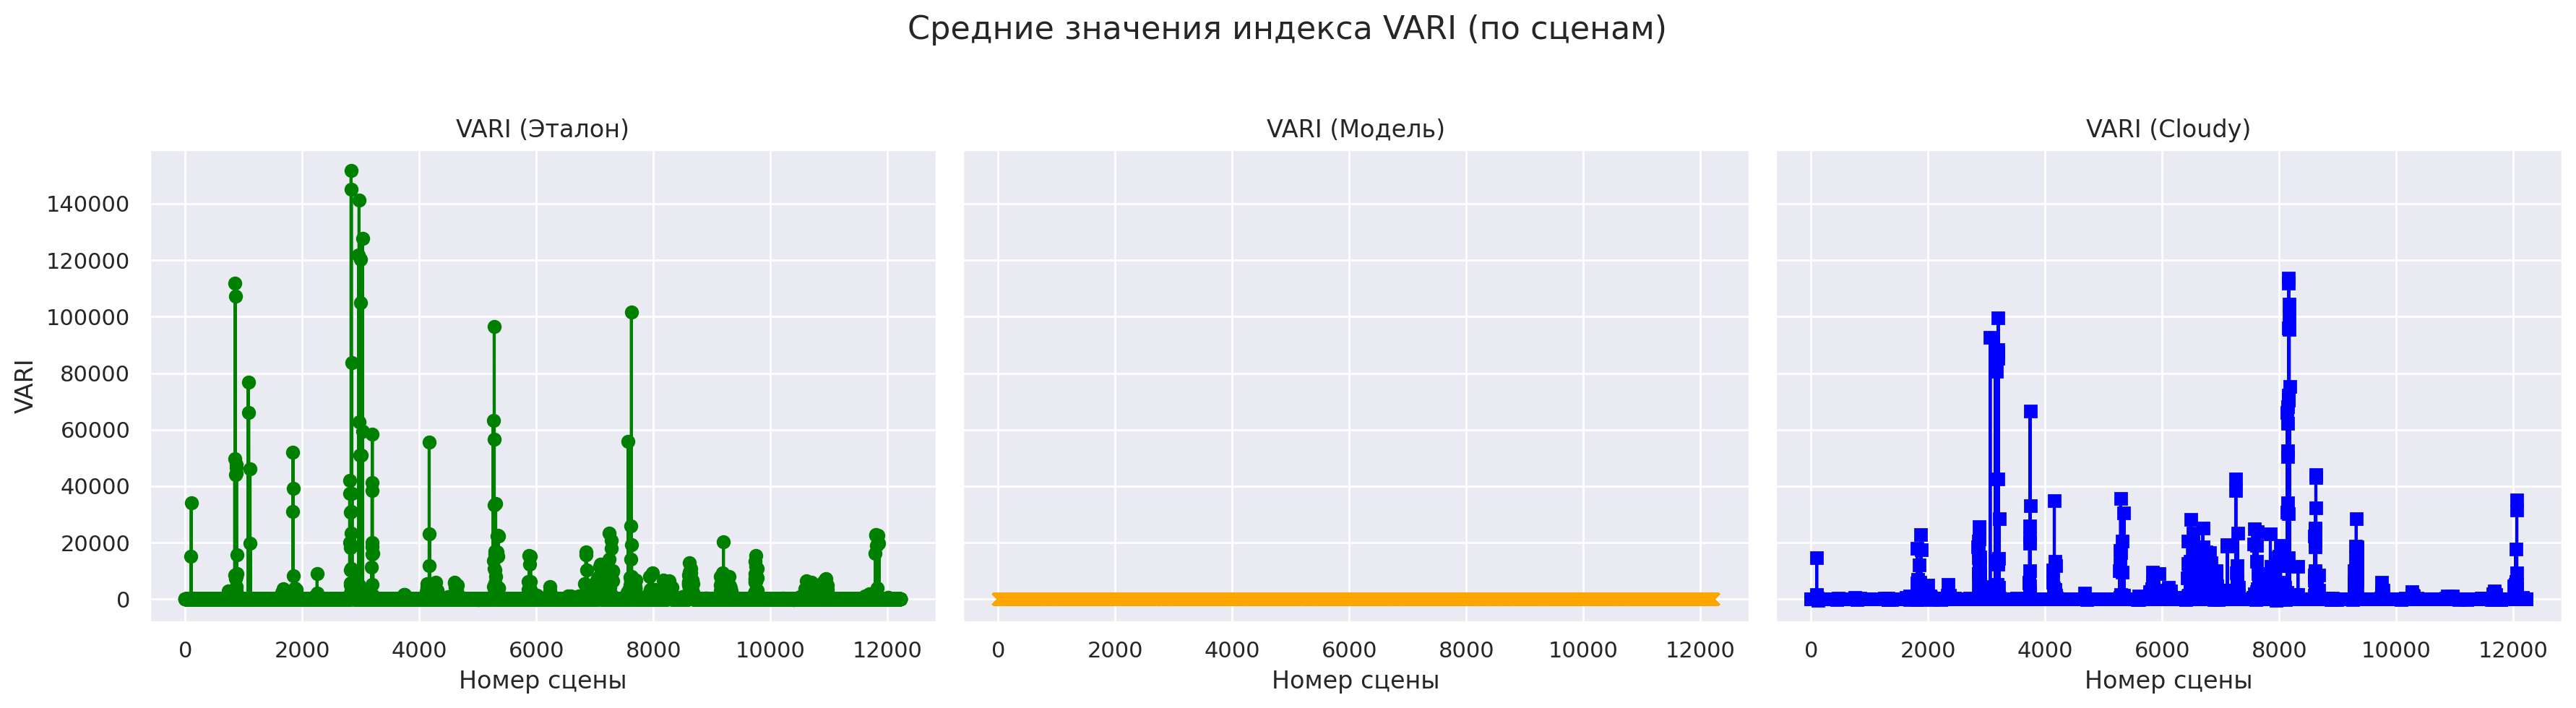

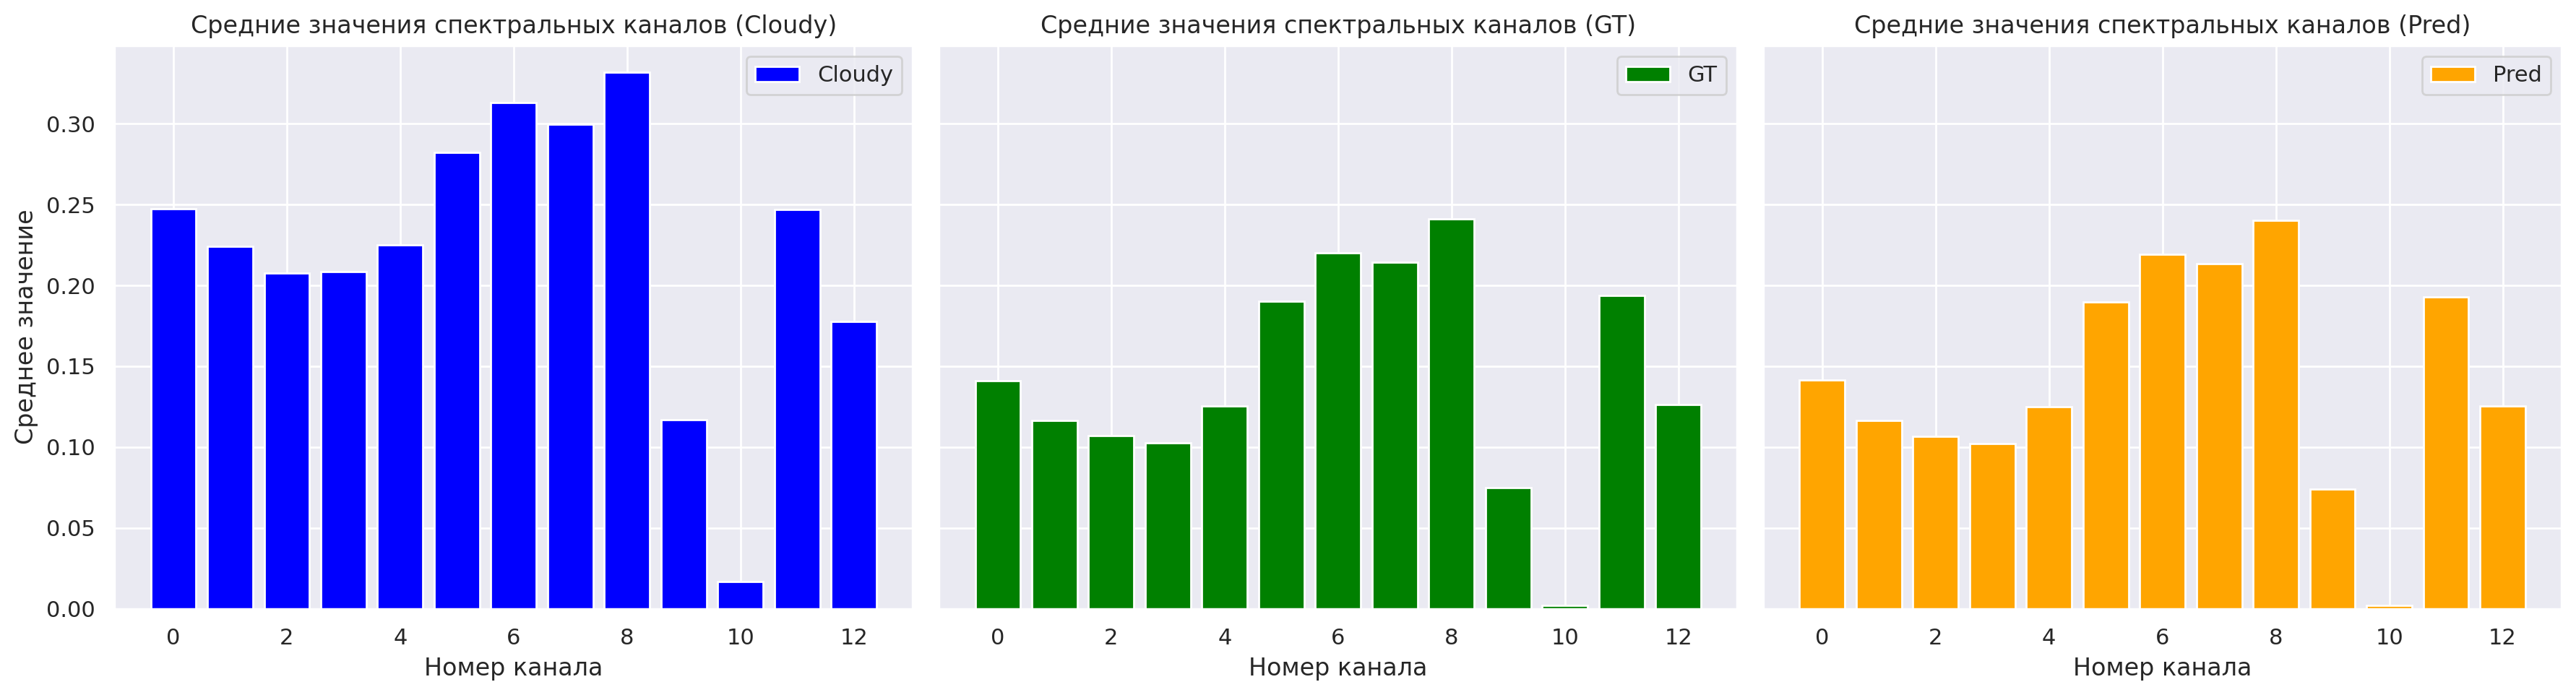


Средние значения каналов (GT, Pred, Cloudy):
Канал 0: GT = 0.1411, Pred = 0.1413, Cloudy = 0.2476
Канал 1: GT = 0.1166, Pred = 0.1165, Cloudy = 0.2242
Канал 2: GT = 0.1069, Pred = 0.1065, Cloudy = 0.2079
Канал 3: GT = 0.1028, Pred = 0.1020, Cloudy = 0.2086
Канал 4: GT = 0.1254, Pred = 0.1249, Cloudy = 0.2252
Канал 5: GT = 0.1901, Pred = 0.1896, Cloudy = 0.2823
Канал 6: GT = 0.2200, Pred = 0.2194, Cloudy = 0.3132
Канал 7: GT = 0.2143, Pred = 0.2133, Cloudy = 0.2997
Канал 8: GT = 0.2411, Pred = 0.2405, Cloudy = 0.3320
Канал 9: GT = 0.0749, Pred = 0.0742, Cloudy = 0.1170
Канал 10: GT = 0.0021, Pred = 0.0019, Cloudy = 0.0168
Канал 11: GT = 0.1936, Pred = 0.1927, Cloudy = 0.2469
Канал 12: GT = 0.1264, Pred = 0.1252, Cloudy = 0.1777

Гистограммы канала 4 (Red):


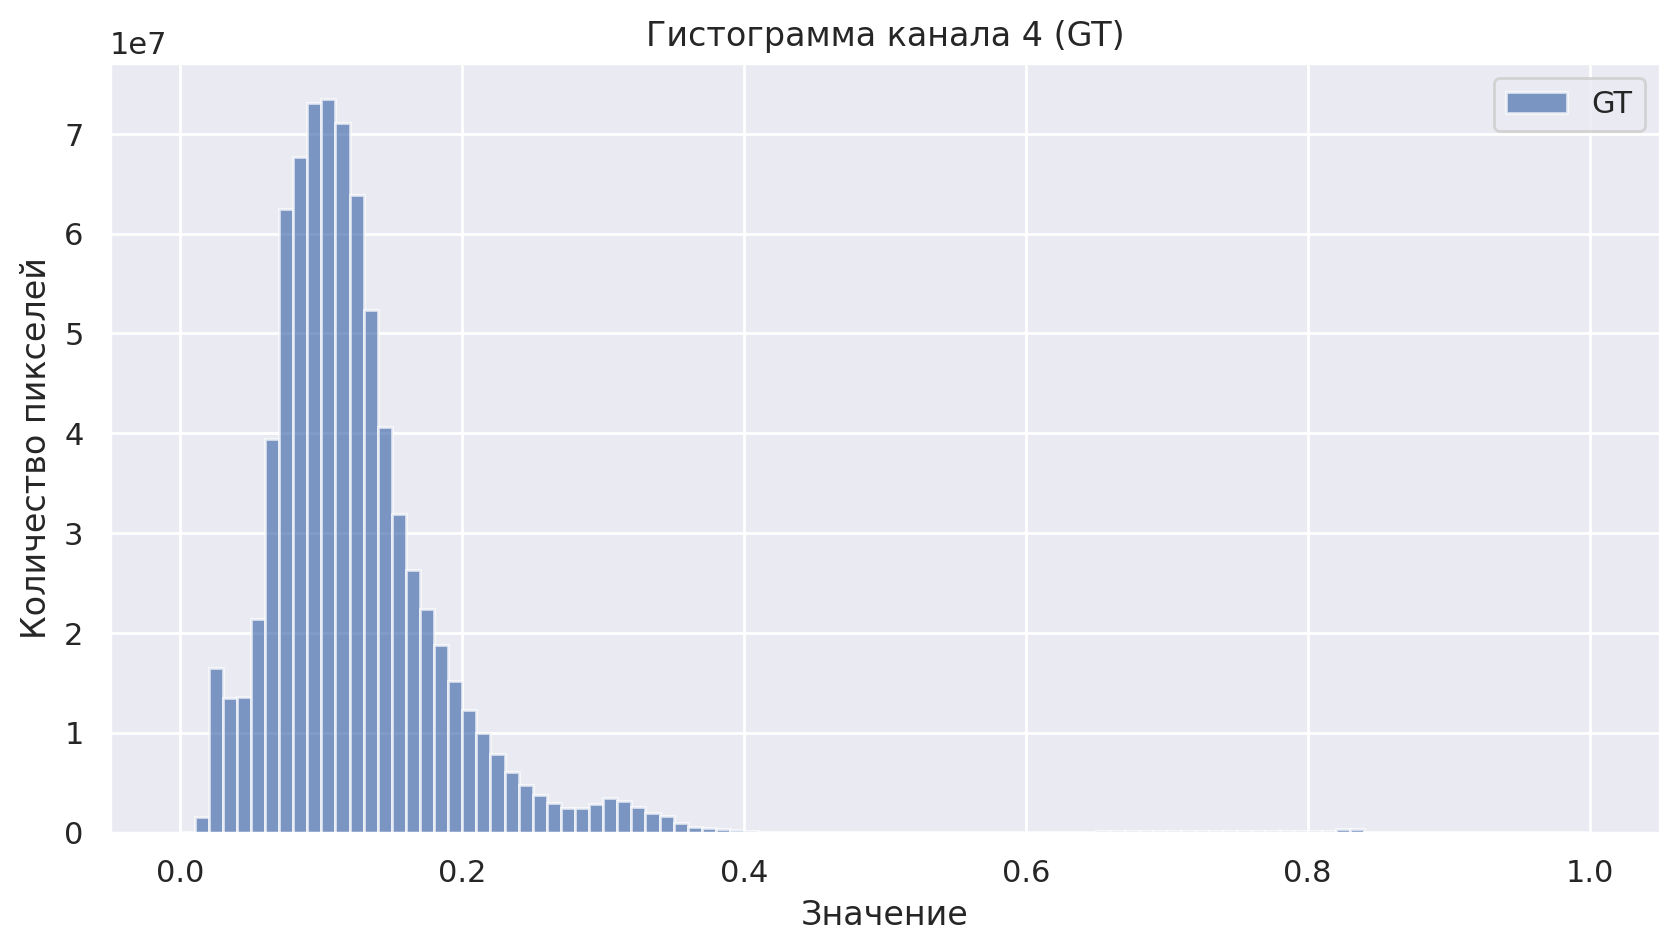

Канал 4 (GT): min = 0.0000, max = 1.0000


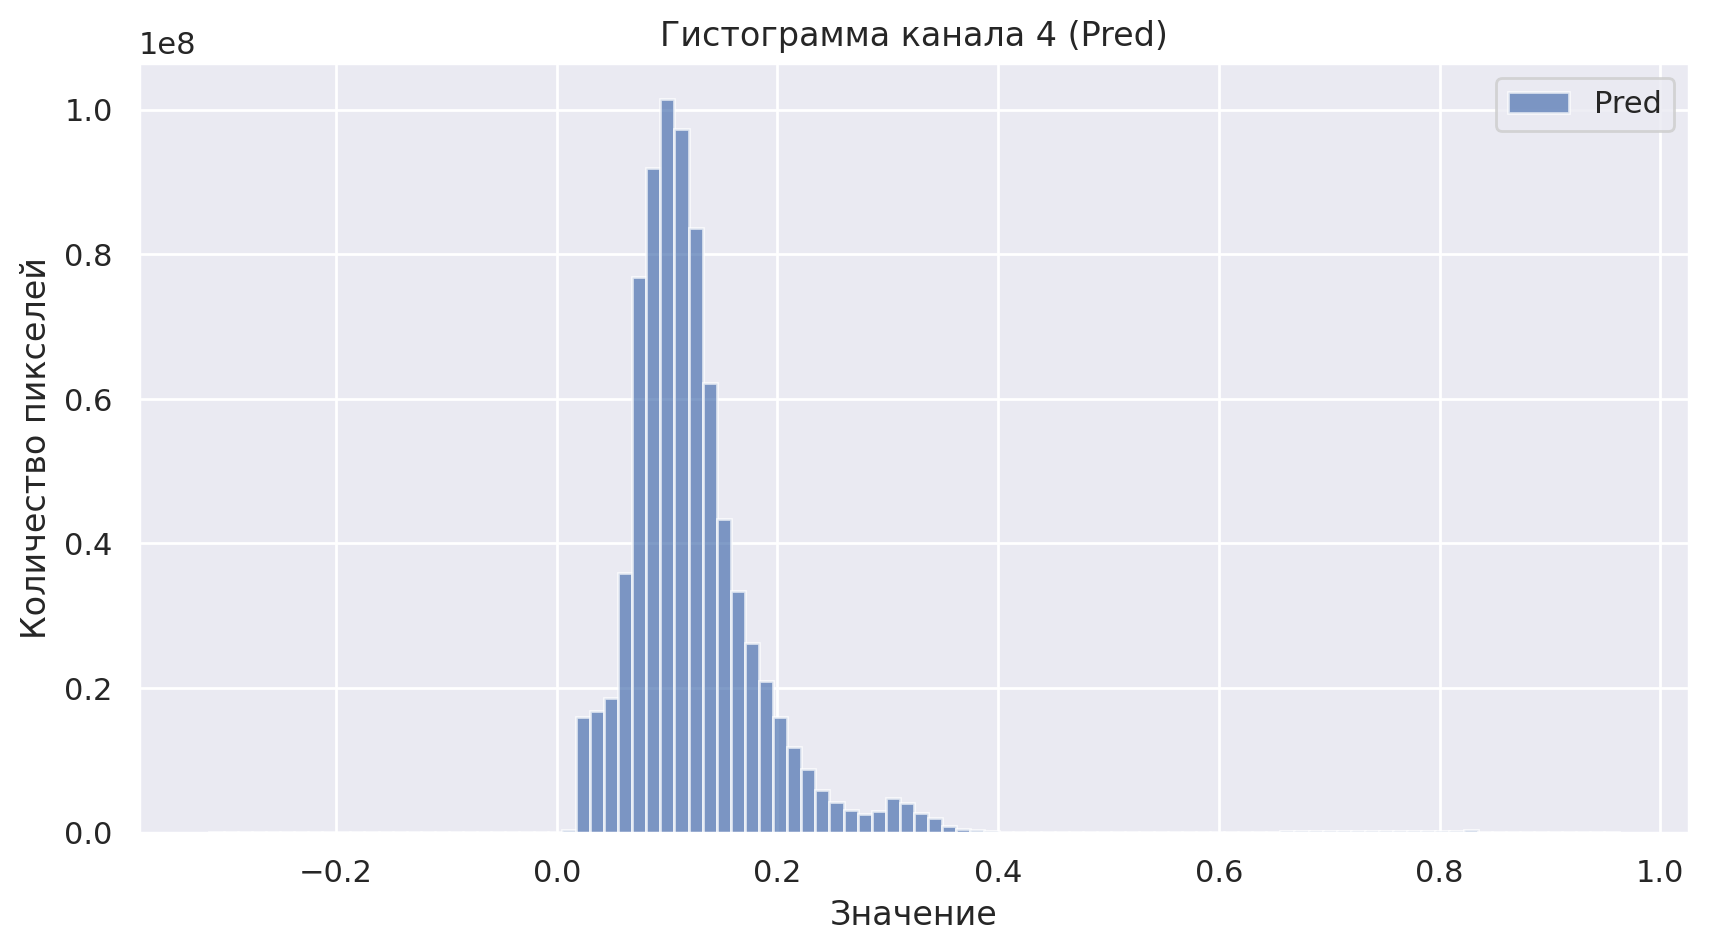

Канал 4 (Pred): min = -0.3147, max = 0.9622


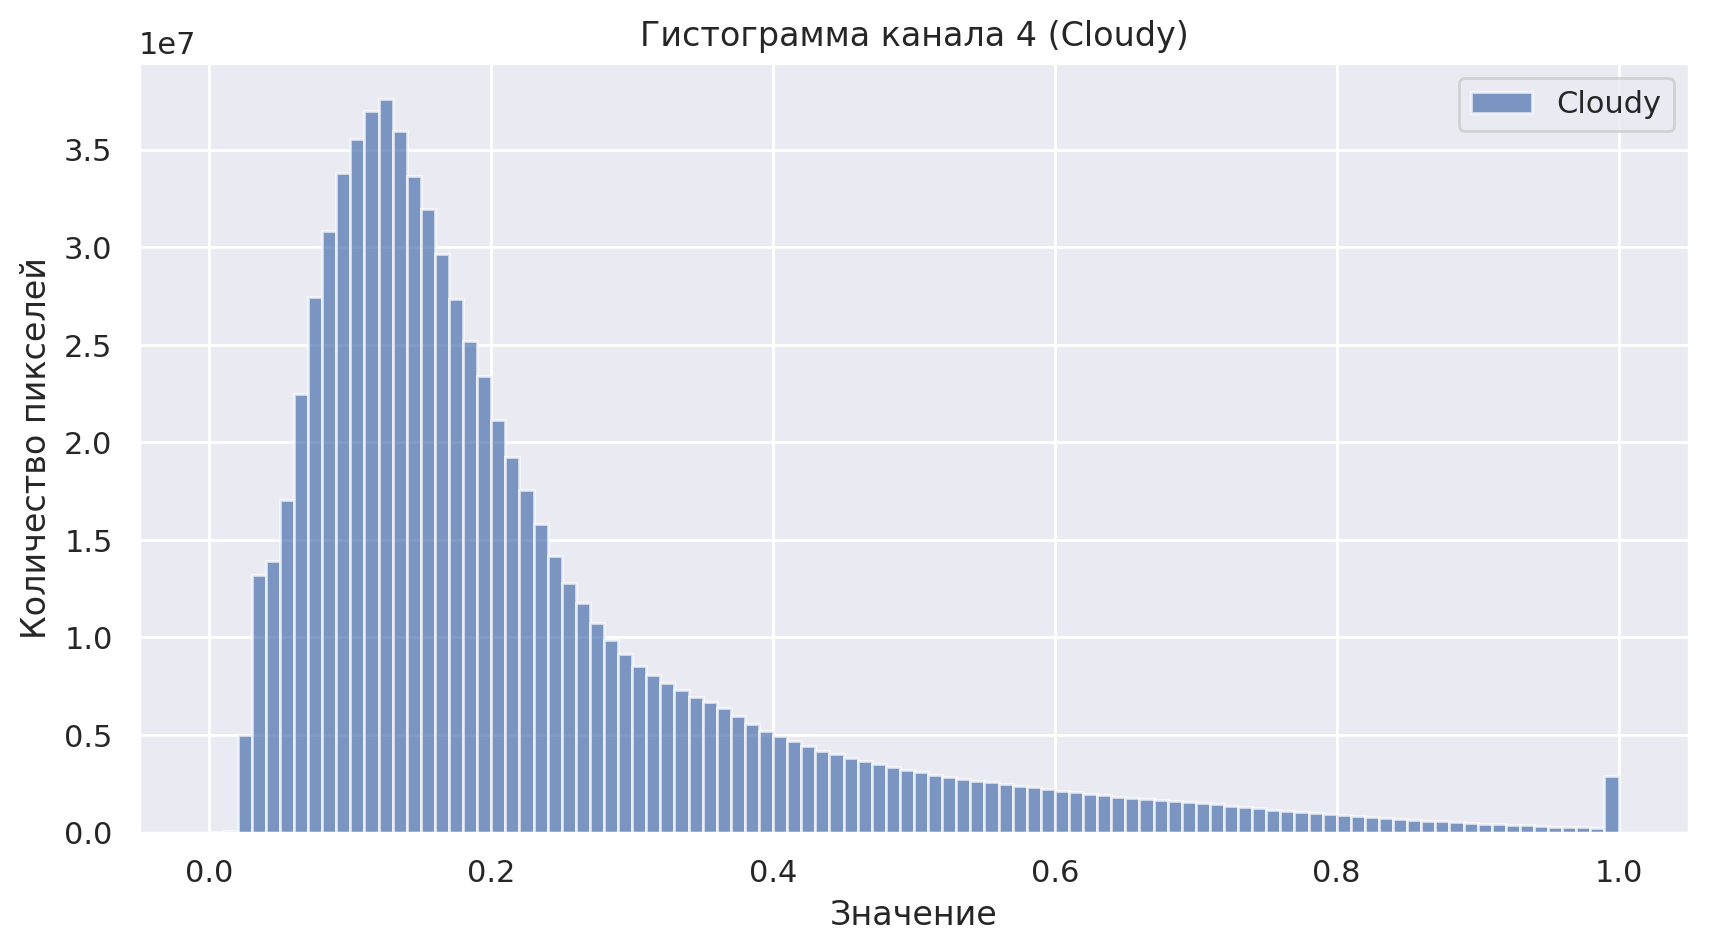

Канал 4 (Cloudy): min = 0.0000, max = 1.0000


In [9]:
import numpy as np
import matplotlib.pyplot as plt

mean_sam = np.mean(sam_values) if len(sam_values) > 0 else 0
print(f"Средний SAM (GT vs Pred): {mean_sam:.4f}")

indices = ["NDWI", "NDMI", "NDVI", "SR", "REP", "EVI", "EVI2", "ARVI", "SAVI", "GOSAVI", "GARI", "VARI"]
mean_indices_by_scene = {idx: {"GT": [], "Pred": [], "Cloudy": []} for idx in indices}

for dct in index_means_list:
    for idx_name in indices:
        (v_gt, v_pred, v_cloudy) = dct[idx_name]
        mean_indices_by_scene[idx_name]["GT"].append(v_gt)
        mean_indices_by_scene[idx_name]["Pred"].append(v_pred)
        mean_indices_by_scene[idx_name]["Cloudy"].append(v_cloudy)

print("\nСредние значения индексов (GT / Pred / Cloudy):")
for idx_name in indices:
    gt_arr = mean_indices_by_scene[idx_name]["GT"]
    pr_arr = mean_indices_by_scene[idx_name]["Pred"]
    cl_arr = mean_indices_by_scene[idx_name]["Cloudy"]
    print(f"{idx_name}: GT={np.mean(gt_arr):.4f}, Pred={np.mean(pr_arr):.4f}, Cloudy={np.mean(cl_arr):.4f}")

def plot_indices_in_row(mean_indices_by_scene, indices):
    for idx_name in indices:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

        axs[0].plot(mean_indices_by_scene[idx_name]["GT"], marker='o', color='green')
        axs[0].set_title(f"{idx_name} (Эталон)")
        axs[0].set_xlabel("Номер сцены")
        axs[0].set_ylabel(f"{idx_name}")
        axs[0].grid(True)

        axs[1].plot(mean_indices_by_scene[idx_name]["Pred"], marker='x', color='orange')
        axs[1].set_title(f"{idx_name} (Модель)")
        axs[1].set_xlabel("Номер сцены")
        axs[1].grid(True)

        axs[2].plot(mean_indices_by_scene[idx_name]["Cloudy"], marker='s', color='blue')
        axs[2].set_title(f"{idx_name} (Cloudy)")
        axs[2].set_xlabel("Номер сцены")
        axs[2].grid(True)

        plt.suptitle(f"Средние значения индекса {idx_name} (по сценам)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Увеличение отступа для общего заголовка
        plt.show()

plot_indices_in_row(mean_indices_by_scene, indices)

channel_means_gt = np.mean(channel_means_gt_list, axis=0)
channel_means_pred = np.mean(channel_means_pred_list, axis=0)
channel_means_cloudy = np.mean(channel_means_cloudy_list, axis=0)

x = np.arange(len(channel_means_gt))

def plot_bar_charts_in_row(channel_means_gt, channel_means_pred, channel_means_cloudy):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    axs[0].bar(x, channel_means_cloudy, color='blue', label="Cloudy")
    axs[0].set_title("Средние значения спектральных каналов (Cloudy)")
    axs[0].set_xlabel("Номер канала")
    axs[0].set_ylabel("Среднее значение")
    axs[0].legend()

    axs[1].bar(x, channel_means_gt, color='green', label="GT")
    axs[1].set_title("Средние значения спектральных каналов (GT)")
    axs[1].set_xlabel("Номер канала")
    axs[1].legend()

    axs[2].bar(x, channel_means_pred, color='orange', label="Pred")
    axs[2].set_title("Средние значения спектральных каналов (Pred)")
    axs[2].set_xlabel("Номер канала")
    axs[2].legend()

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_bar_charts_in_row(channel_means_gt, channel_means_pred, channel_means_cloudy)

print("\nСредние значения каналов (GT, Pred, Cloudy):")
for i in range(len(channel_means_gt)):
    print(f"Канал {i}: GT = {channel_means_gt[i]:.4f}, Pred = {channel_means_pred[i]:.4f}, Cloudy = {channel_means_cloudy[i]:.4f}")

def plot_histogram(data_list, channel_idx, label):
    all_vals = []
    for data in data_list:
        channel_data = data[channel_idx].numpy().flatten()
        all_vals.append(channel_data)
    all_vals = np.concatenate(all_vals)

    min_val, max_val = all_vals.min(), all_vals.max()

    plt.figure(figsize=(10, 5))
    plt.hist(all_vals, bins=100, alpha=0.7, label=label)
    plt.title(f"Гистограмма канала {channel_idx} ({label})")
    plt.xlabel("Значение")
    plt.ylabel("Количество пикселей")
    plt.legend()
    plt.show()

    print(f"Канал {channel_idx} ({label}): min = {min_val:.4f}, max = {max_val:.4f}")

print("\nГистограммы канала 4 (Red):")
plot_histogram(gt_data_list, channel_idx=4, label="GT")
plot_histogram(pred_data_list, channel_idx=4, label="Pred")
plot_histogram(cloudy_data_list, channel_idx=4, label="Cloudy")

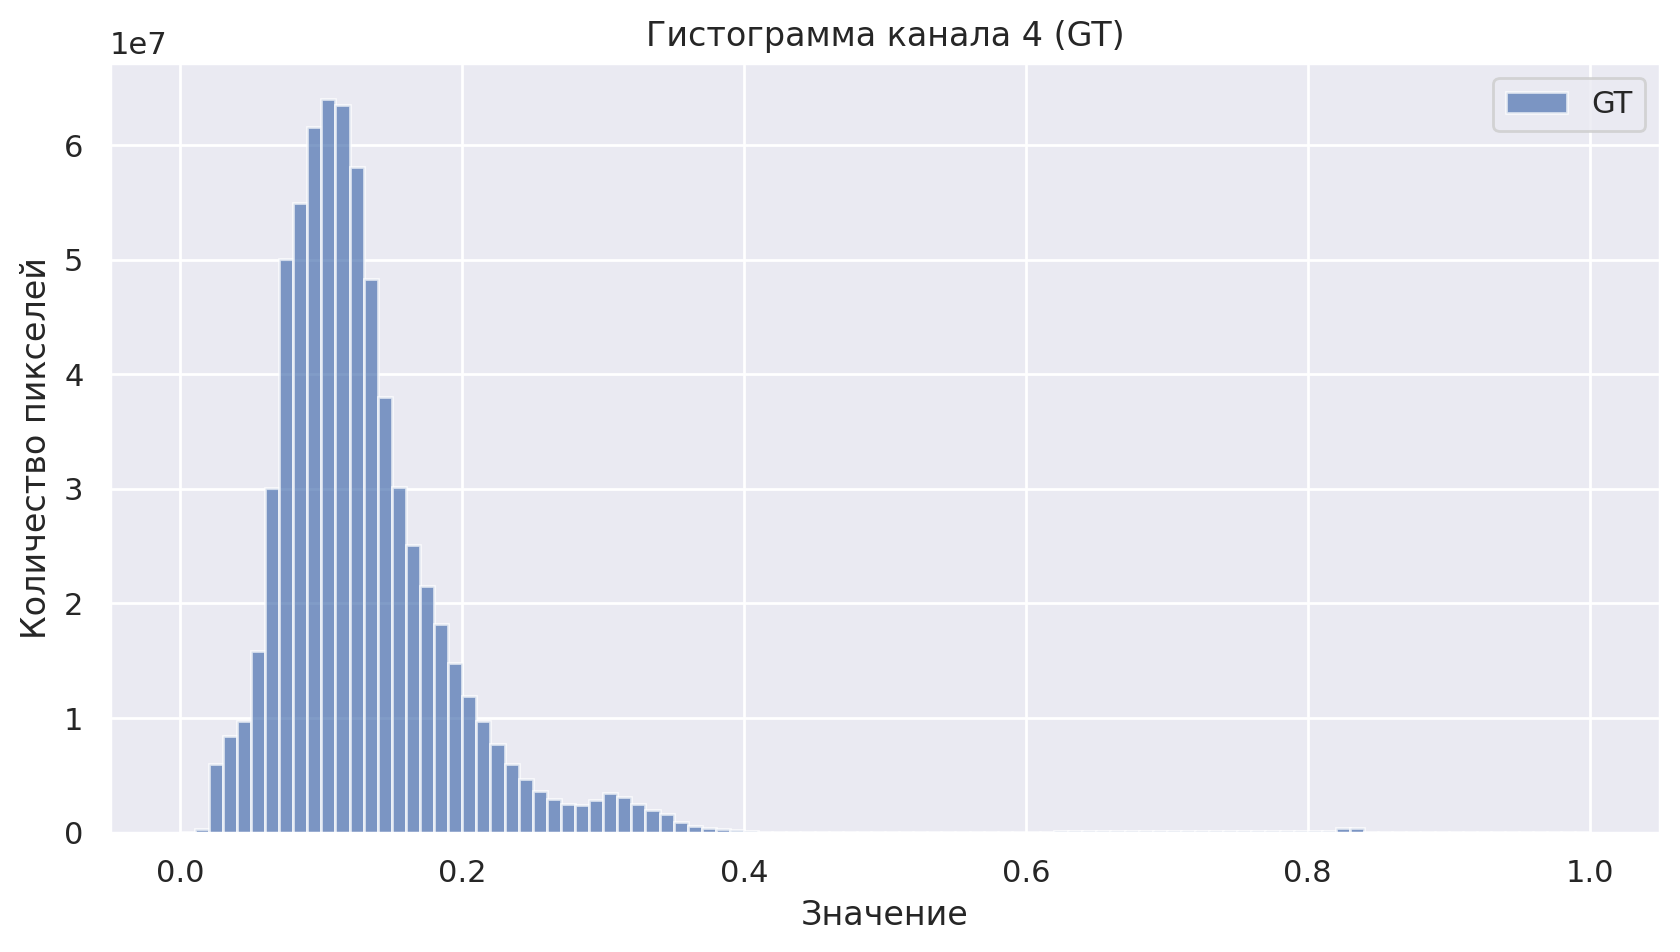

Канал 4 (GT): min = 0.0000, max = 1.0000


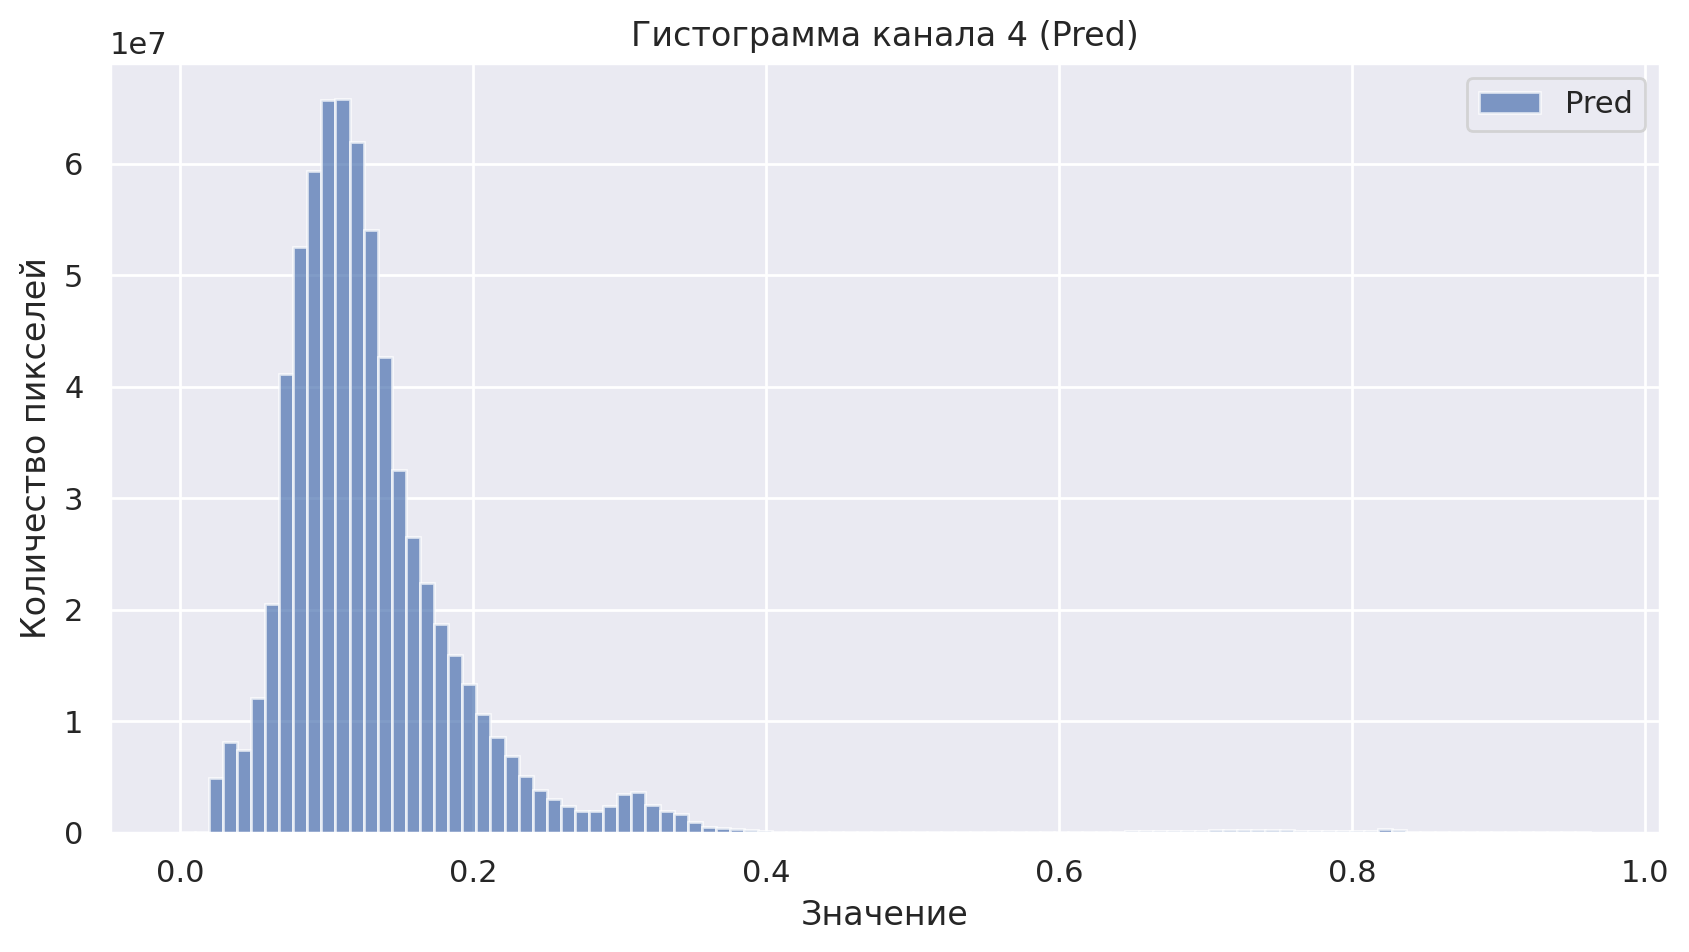

Канал 4 (Pred): min = 0.0000, max = 0.9622


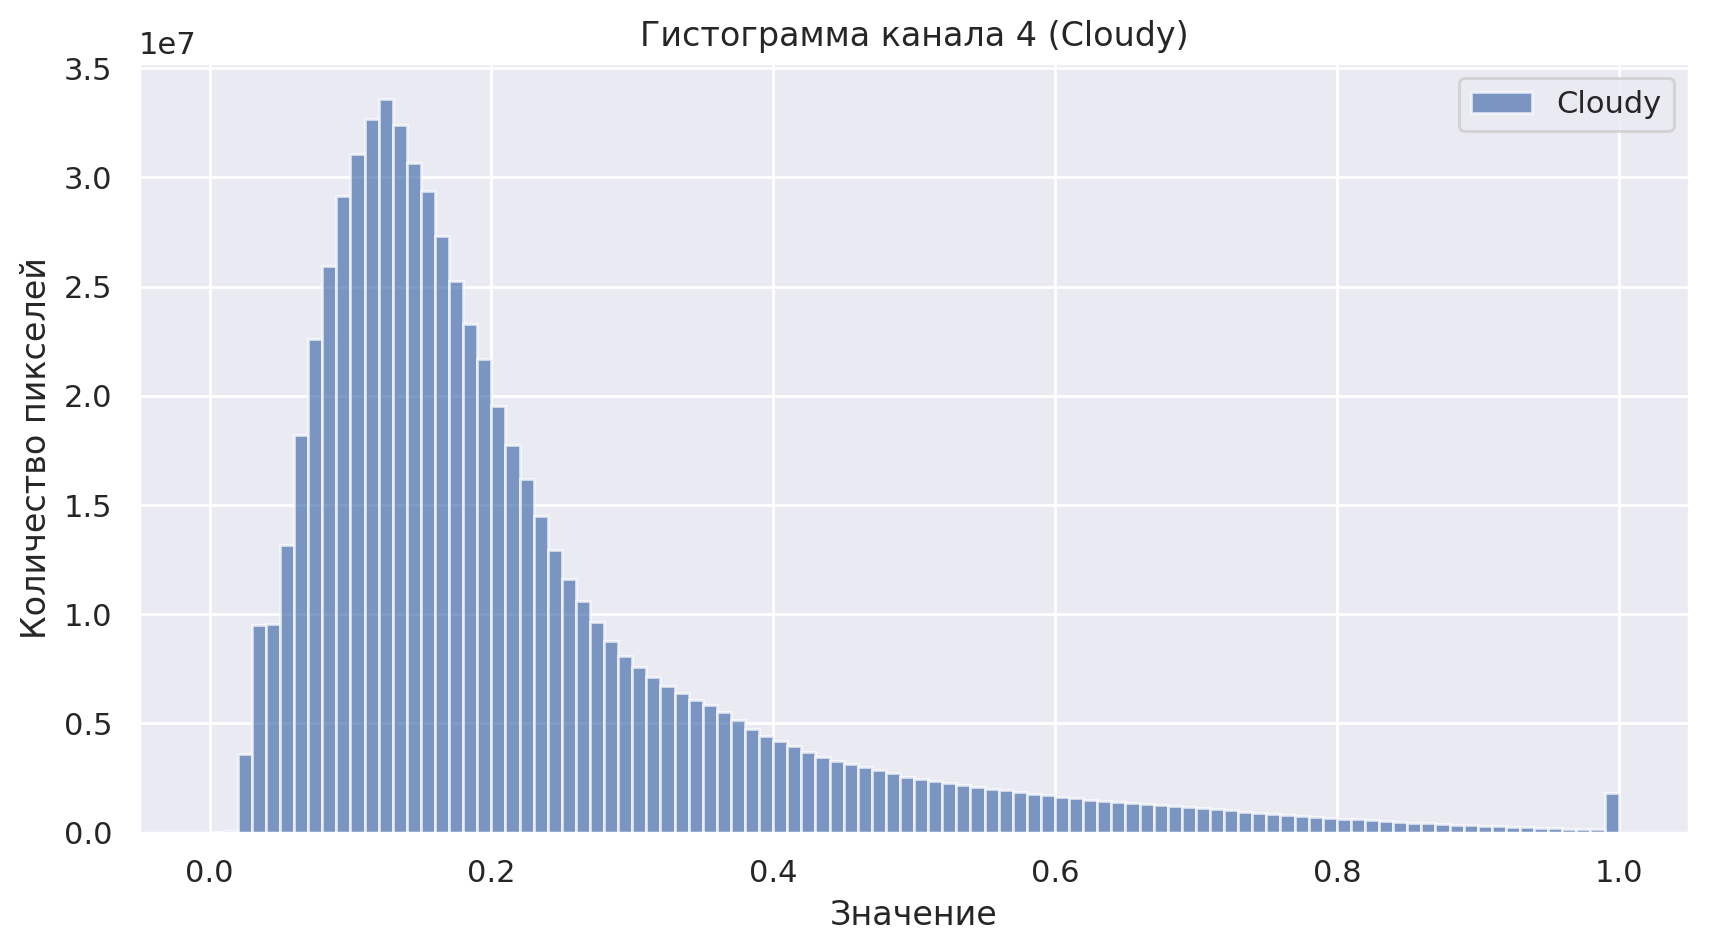

Канал 4 (Cloudy): min = 0.0000, max = 1.0000


In [11]:
plot_histogram(gt_data_list, channel_idx=4, label="GT")
plot_histogram(pred_data_list, channel_idx=4, label="Pred")
plot_histogram(cloudy_data_list, channel_idx=4, label="Cloudy")

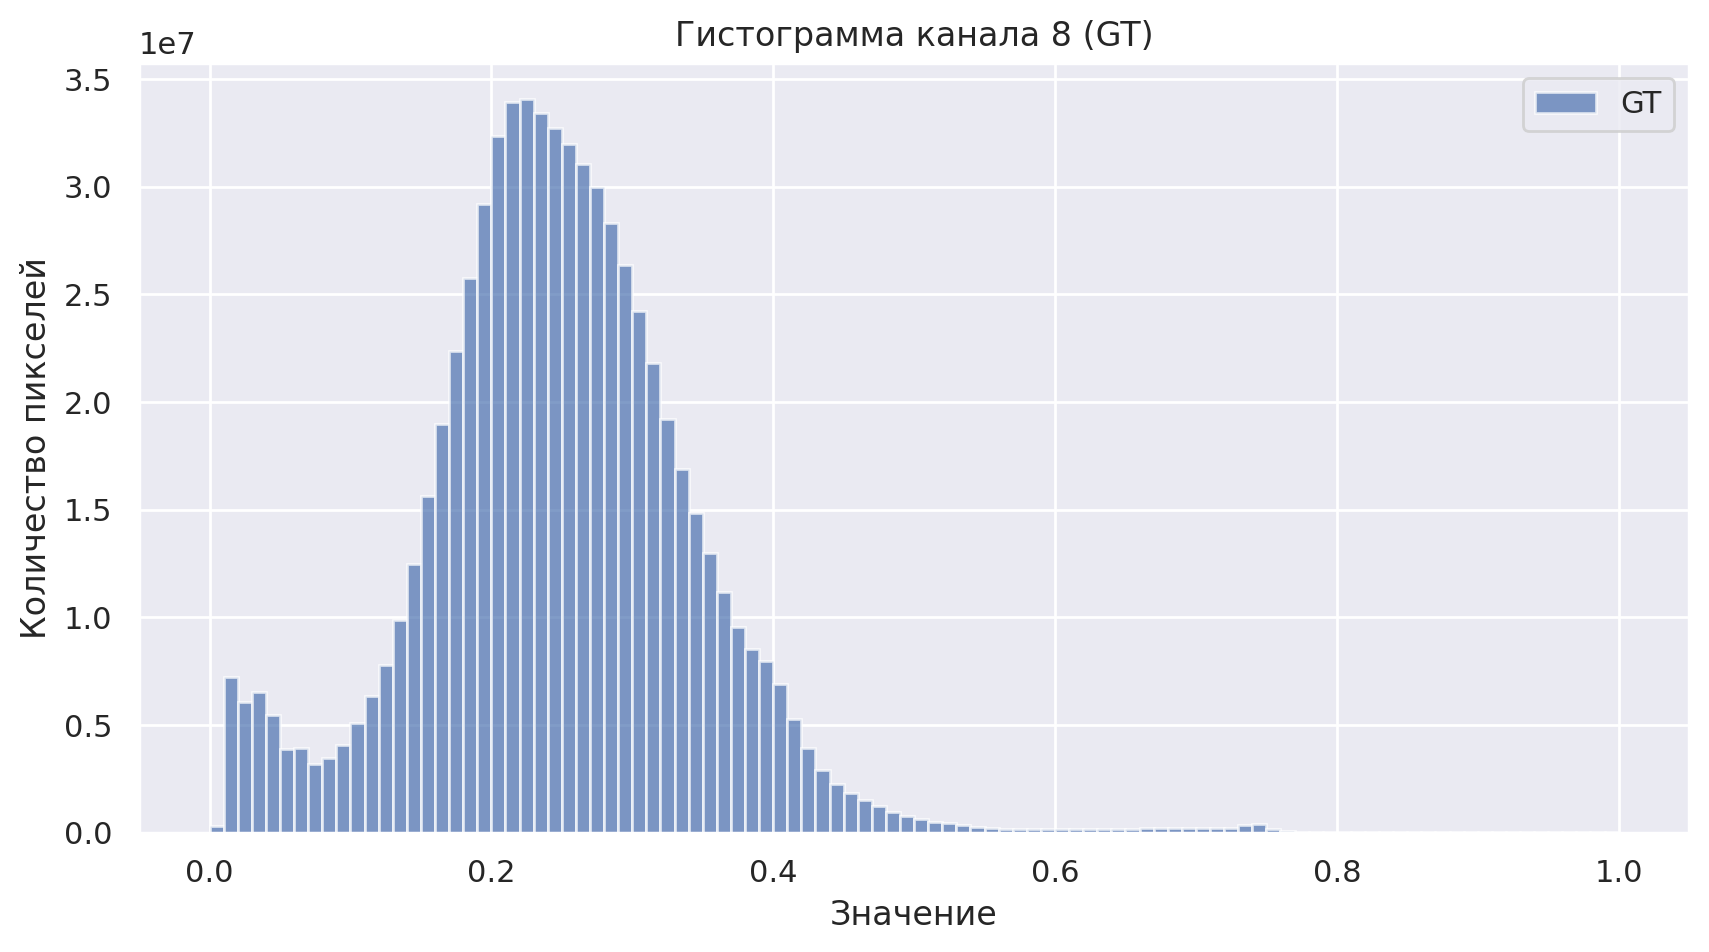

Канал 8 (GT): min = 0.0000, max = 1.0000


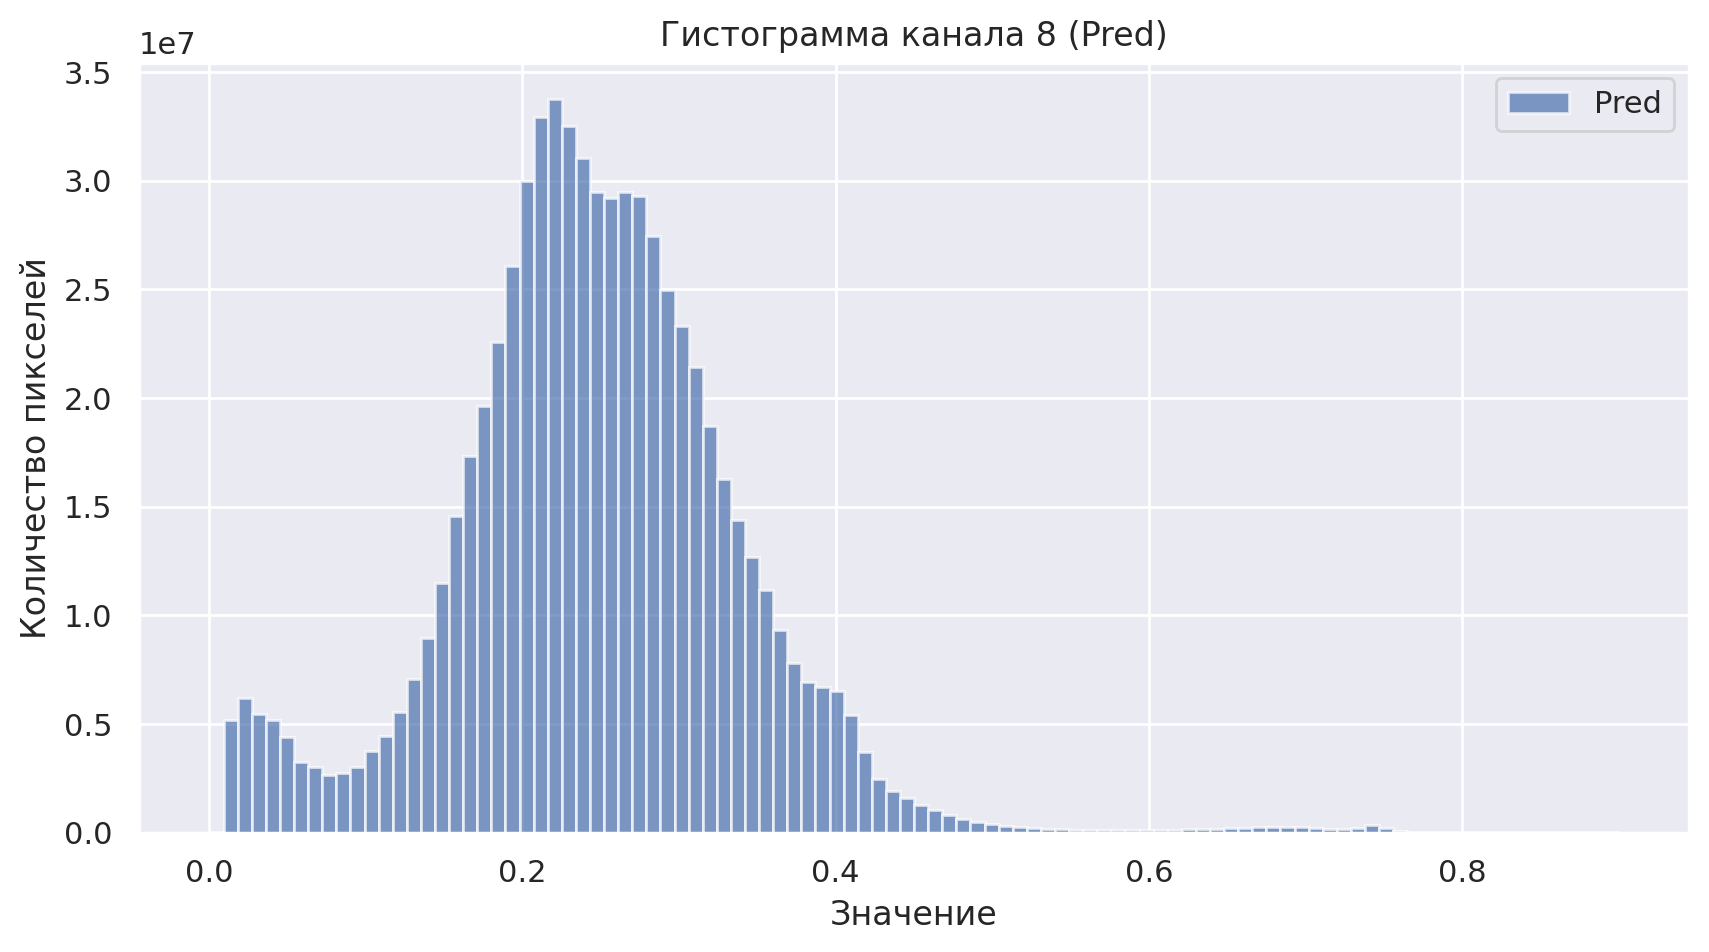

Канал 8 (Pred): min = 0.0002, max = 0.8999


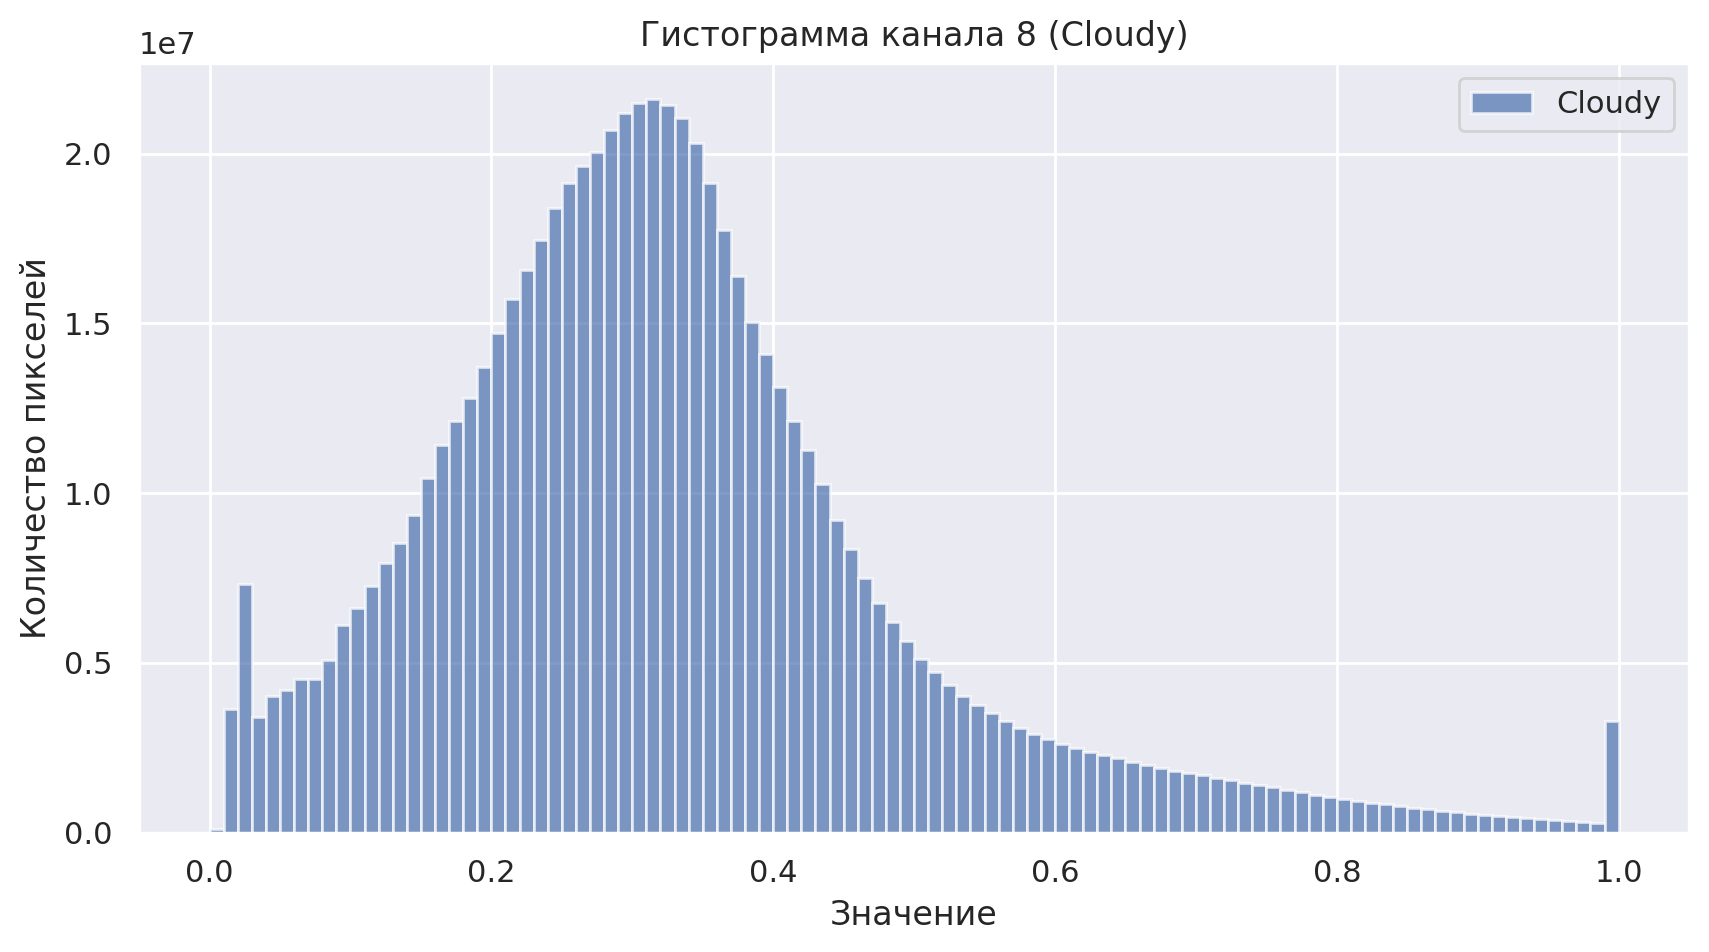

Канал 8 (Cloudy): min = 0.0000, max = 1.0000


In [12]:
plot_histogram(gt_data_list, channel_idx=8, label="GT")
plot_histogram(pred_data_list, channel_idx=8, label="Pred")
plot_histogram(cloudy_data_list, channel_idx=8, label="Cloudy")

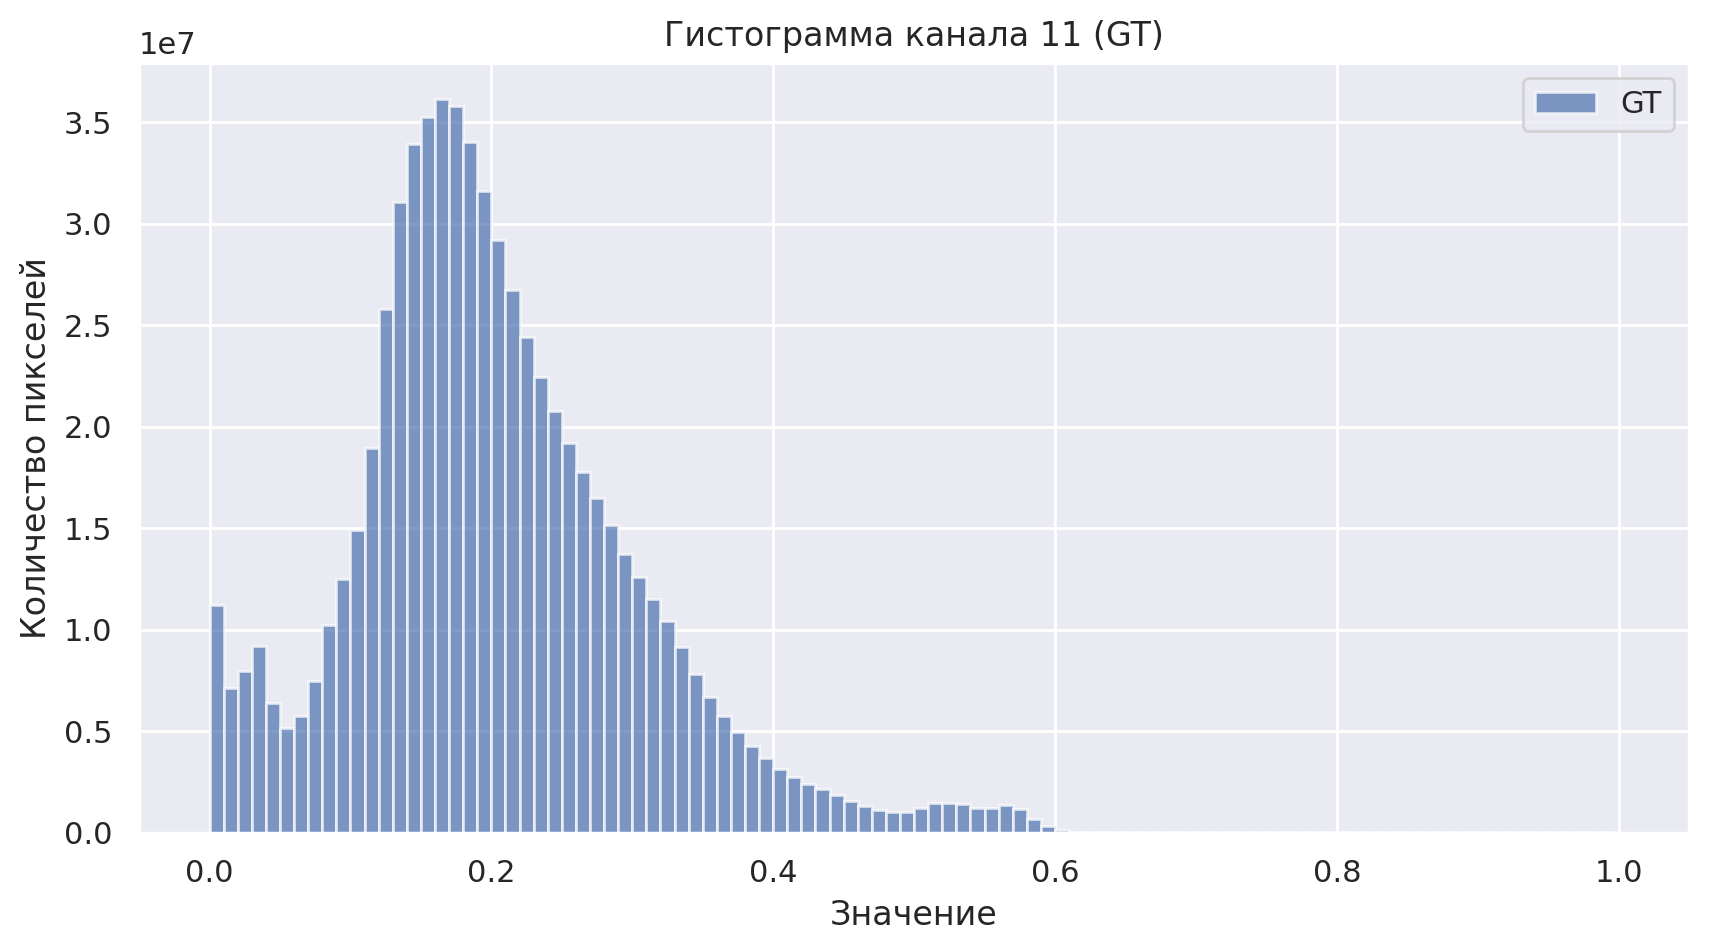

Канал 11 (GT): min = 0.0000, max = 1.0000


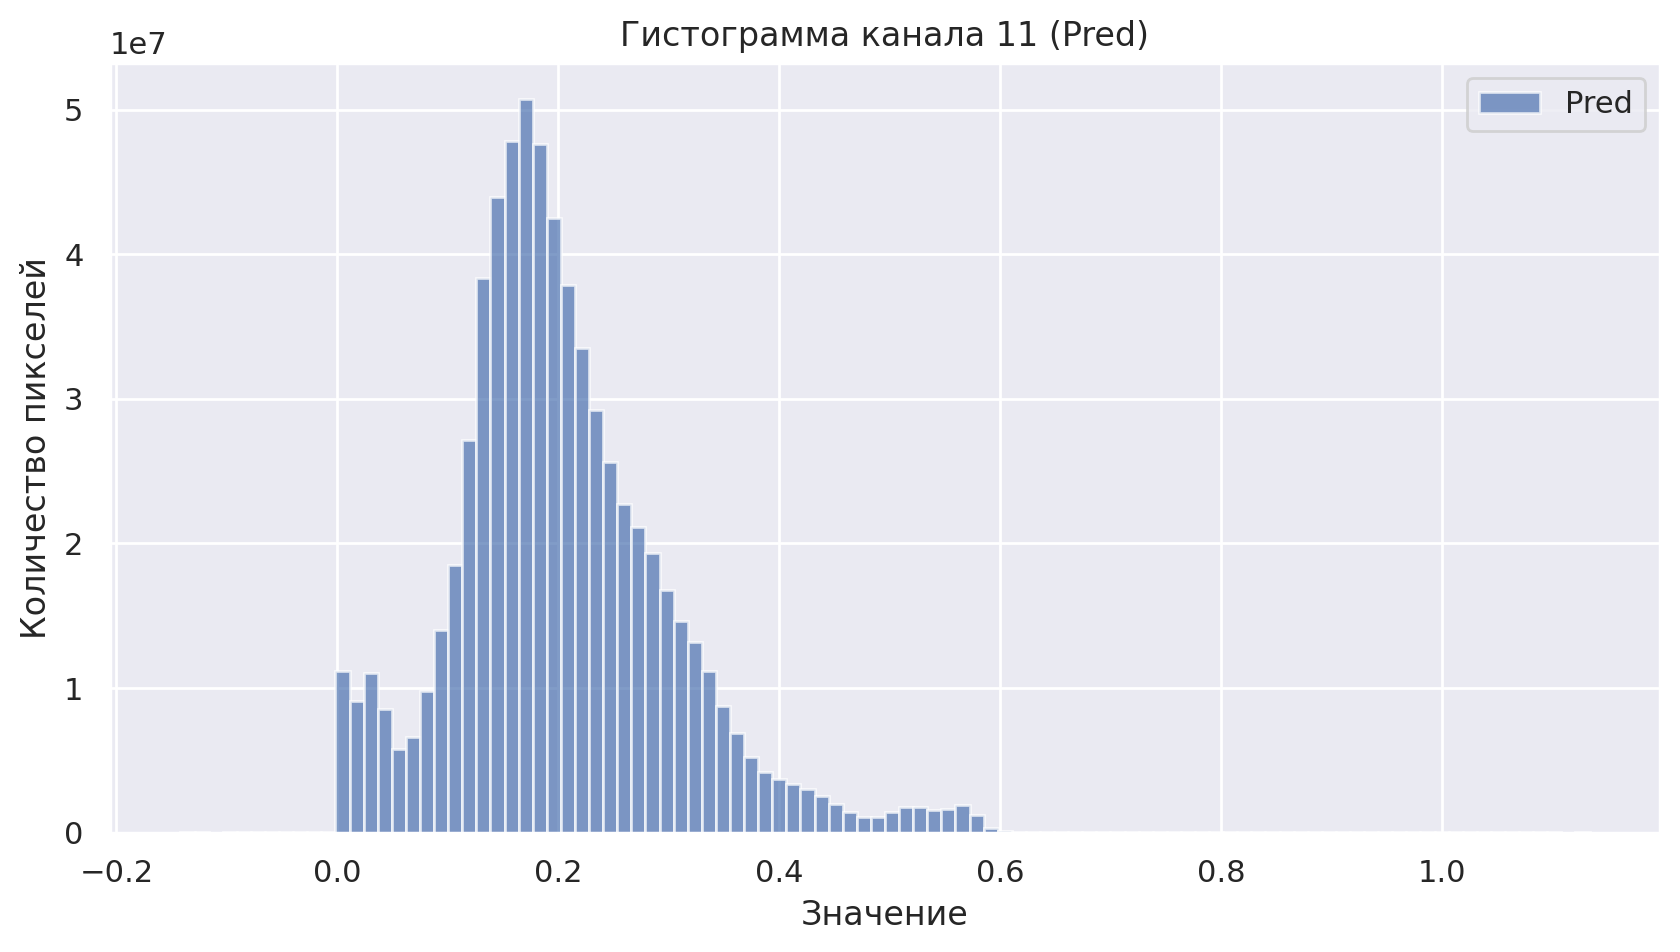

Канал 11 (Pred): min = -0.1420, max = 1.1334


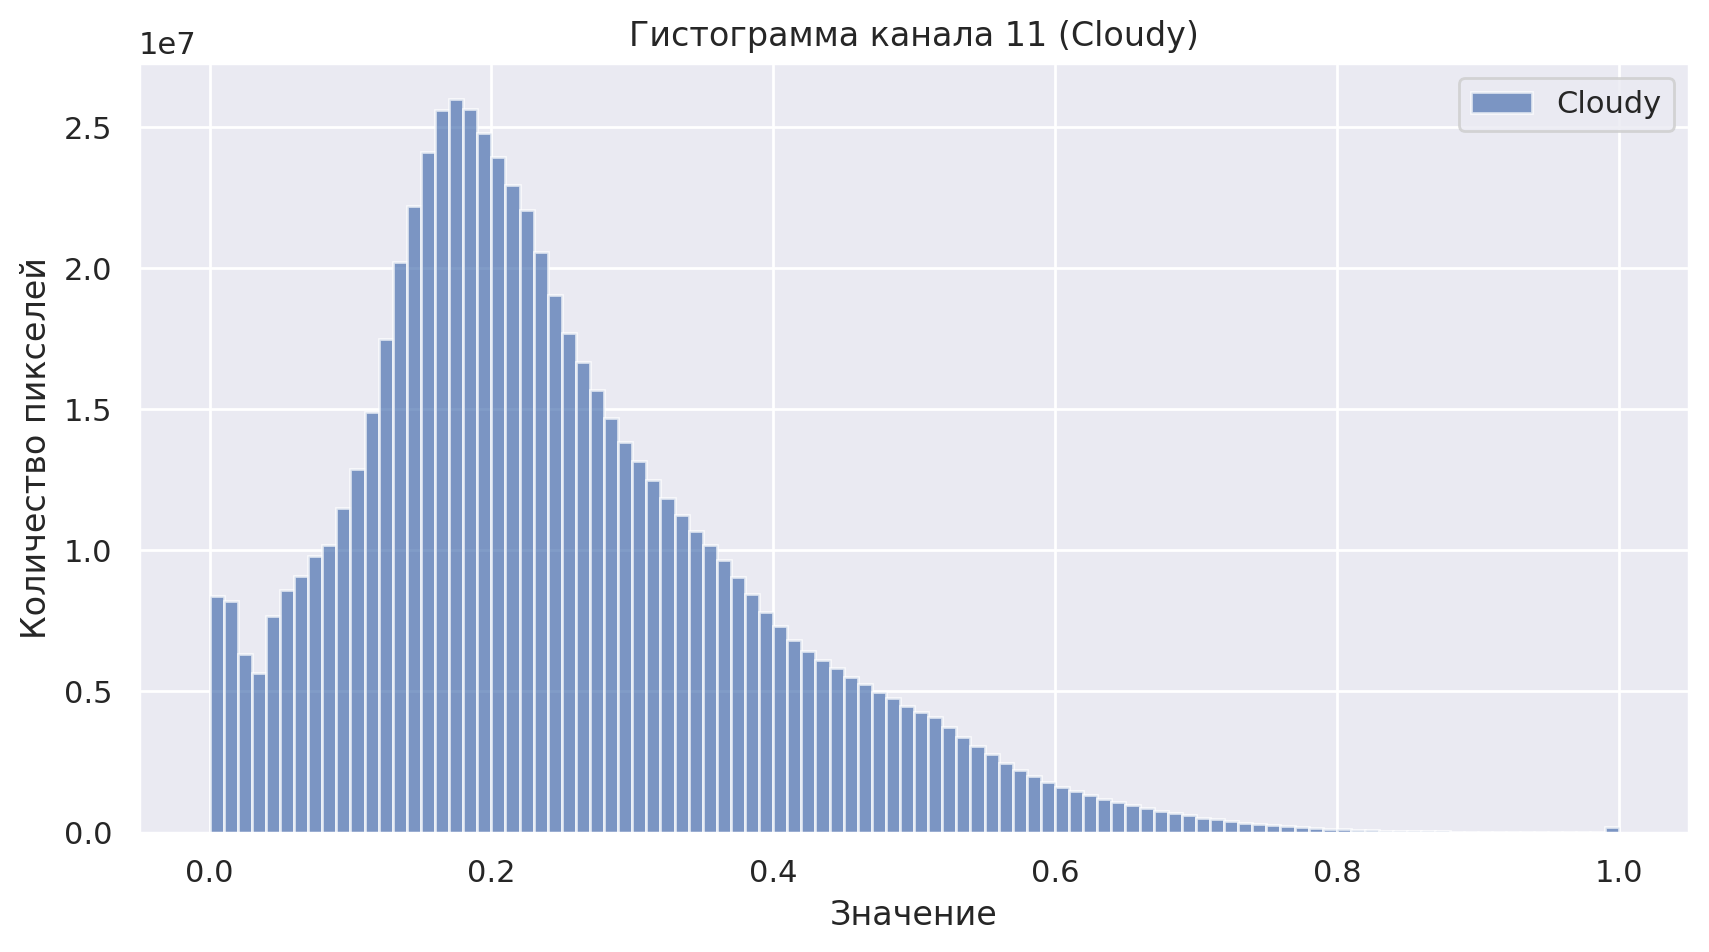

Канал 11 (Cloudy): min = 0.0000, max = 1.0000


In [13]:
plot_histogram(gt_data_list, channel_idx=11, label="GT")
plot_histogram(pred_data_list, channel_idx=11, label="Pred")
plot_histogram(cloudy_data_list, channel_idx=11, label="Cloudy")

In [7]:
def analyze_channel(channel_pred, channel_name):
    """Helper function to analyze negative values in a channel"""
    neg_count = np.sum(channel_pred < 0)
    total_pixels = channel_pred.size
    return {
        'name': channel_name,
        'neg_count': neg_count,
        'total_pixels': total_pixels,
        'percentage': (neg_count/total_pixels)*100 if total_pixels > 0 else 0
    }

def plot_enhanced_analysis(gt_data, pred_data, filename, stats):
    """
    Enhanced analysis function that shows visualizations for images 
    with negative values in multiple channels
    """
    channels = {
        'Blue': 2,
        'Green': 3,
        'NIR': 8
    }
    
    print(f"\nFile: {filename}")
    
    for name, channel_idx in channels.items():
        channel_gt = gt_data[channel_idx].numpy()
        channel_pred = pred_data[channel_idx].numpy()
        
        print(f"\n{name} (Channel {channel_idx}) ranges:")
        print(f"GT range: {channel_gt.min():.4f} ... {channel_gt.max():.4f}")
        print(f"Pred range: {channel_pred.min():.4f} ... {channel_pred.max():.4f}")
        
        neg_mask_gt = channel_gt < 0
        neg_mask_pred = channel_pred < 0
        neg_count_gt = np.sum(neg_mask_gt)
        total_pixels = channel_gt.size
        
        print(f"GT negative values: {neg_count_gt}/{total_pixels} ({(neg_count_gt/total_pixels)*100:.2f}%)")
        print(f"Pred negative values: {stats[name]['neg_count']}/{total_pixels} "
              f"({stats[name]['percentage']:.2f}%)")
        
        if neg_count_gt > 0:
            print(f"GT negative range: {channel_gt[neg_mask_gt].min():.4f} to {channel_gt[neg_mask_gt].max():.4f}")
        if stats[name]['neg_count'] > 0:
            print(f"Pred negative range: {channel_pred[neg_mask_pred].min():.4f} to {channel_pred[neg_mask_pred].max():.4f}")

    def create_rgb(data):
        rgb = np.stack([
            data[4].numpy(),  # Red
            data[3].numpy(),  # Green
            data[2].numpy()   # Blue
        ], axis=-1)
        
        rgb_min, rgb_max = rgb.min(), rgb.max()
        rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)
        return rgb_norm

    fig = plt.figure(figsize=(15, 20))
    
    for idx, (name, channel_idx) in enumerate(channels.items(), 1):
        plt.subplot(4, 2, idx*2-1)
        
        channel_gt = gt_data[channel_idx].numpy().flatten()
        channel_pred = pred_data[channel_idx].numpy().flatten()
        
        plt.hist(channel_gt, bins=100, alpha=0.5, label='GT')
        plt.hist(channel_pred, bins=100, alpha=0.5, label='Pred')
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        plt.title(f'{name} (Channel {channel_idx}) Histogram\nFile: {filename}')
        plt.xlabel('Value')
        plt.ylabel('Pixel Count')
        plt.legend()
        
        plt.subplot(4, 2, idx*2)
        
        channel_gt = gt_data[channel_idx].numpy()
        channel_pred = pred_data[channel_idx].numpy()
        combined_channel = np.hstack([channel_gt, channel_pred])
        
        neg_mask_gt = channel_gt < 0
        neg_mask_pred = channel_pred < 0
        combined_mask = np.hstack([neg_mask_gt, neg_mask_pred])
        
        im = plt.imshow(combined_channel, cmap='RdYlBu')
        plt.imshow(np.ma.masked_where(~combined_mask, combined_channel), 
                  cmap='binary', alpha=0.3)
        
        plt.colorbar(im, label=f'{name} Value')
        plt.title(f'{name} Comparison (негативные значения затемнены)\nLeft: GT, Right: Pred')
        plt.axis('off')
    
    plt.subplot(4, 2, 7)
    plt.imshow(create_rgb(gt_data))
    plt.title(f'RGB Visualization (GT)\nFile: {filename}')
    plt.axis('off')
    
    plt.subplot(4, 2, 8)
    plt.imshow(create_rgb(pred_data))
    plt.title(f'RGB Visualization (Pred)\nFile: {filename}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

channels = {
    'Aerosol': 1,
    'Blue': 2,
    'Green': 3,
    'Red': 4,
    'NIR': 8
}

print(f"Total files available: {len(gt_files)}")
print("Analyzing files for negative values...")

file_stats = []
for i, (gt_data, pred_data) in enumerate(zip(gt_data_list, pred_data_list)):
    filename = gt_files[i]
    
    channel_stats = {}
    any_negative = False
    
    for name, channel_idx in channels.items():
        channel_pred = pred_data[channel_idx].numpy()
        stats = analyze_channel(channel_pred, name)
        channel_stats[name] = stats
        if stats['neg_count'] > 0:
            any_negative = True
    
    if any_negative:
        file_stats.append({
            'filename': filename,
            'gt_data': gt_data,
            'pred_data': pred_data,
            'channel_stats': channel_stats,
            'total_neg': sum(stats['neg_count'] for stats in channel_stats.values())
        })

file_stats.sort(key=lambda x: x['total_neg'], reverse=True)

print(f"\nFound {len(file_stats)} files with negative values")
if file_stats:
    print("\nTop 5 files with most negative pixels (across all analyzed channels):")
    for i, stats in enumerate(file_stats[:10]):
        print(f"\n=== File {i+1}: {stats['filename']} ===")
        for channel, channel_stats in stats['channel_stats'].items():
            print(f"{channel}: {channel_stats['neg_count']} negative pixels "
                  f"({channel_stats['percentage']:.2f}%)")
        plot_enhanced_analysis(
            stats['gt_data'], 
            stats['pred_data'], 
            stats['filename'],
            stats['channel_stats']
        )
else:
    print("\nNo files with negative values in Pred found.")

Total files available: 10569
Analyzing files for negative values...

Found 0 files with negative values

No files with negative values in Pred found.


In [8]:
def analyze_negative_values():
    channel_names = {
        1: 'B1 (cb)',
        2: 'B2 (blue)',
        3: 'B3 (green)',
        4: 'B4 (red)',
        5: 'B5 (re1)',
        6: 'B6 (re2)',
        7: 'B7 (re3)',
        8: 'B8 (nir)',
        9: 'B8A (nir2)',
        10: 'B9 (waterVapor)',
        11: 'B10 (cirrus)',
        12: 'B11 (swir1)',
        13: 'B12 (swir2)'
    }
    
    channel_stats = {i: {'images_with_neg': 0, 'images': []} for i in channel_names.keys()}
    
    clean_images = set(gt_files)  # Начинаем со всех файлов
    total_images = len(pred_data_list)
    
    for i, pred_data in enumerate(pred_data_list):
        filename = gt_files[i]
        has_negative = False
        
        for channel_idx in channel_names.keys():
            numpy_idx = channel_idx - 1
            
            channel_data = pred_data[numpy_idx].numpy()
            neg_mask = channel_data < 0
            neg_count = np.sum(neg_mask)
            
            if neg_count > 0:
                has_negative = True
                channel_stats[channel_idx]['images_with_neg'] += 1
                channel_stats[channel_idx]['images'].append({
                    'filename': filename,
                    'neg_count': neg_count,
                    'total_pixels': channel_data.size,
                    'percentage': (neg_count/channel_data.size)*100,
                    'neg_range': (float(channel_data[neg_mask].min()), float(channel_data[neg_mask].max()))
                })
        
        if has_negative:
            clean_images.discard(filename)
    
    print(f"\nTotal images analyzed: {total_images}")
    print(f"Images with NO negative values in ANY channel: {len(clean_images)}")
    print(f"Images with negative values: {total_images - len(clean_images)}")
    print("\nDetailed statistics by channel:")
    print("-" * 100)
    print(f"{'Channel':<20} {'Images with neg.':<20} {'Percentage':<15} {'Max neg count':<15} {'Worst case %':<15}")
    print("-" * 100)
    
    for channel_idx, stats in channel_stats.items():
        if stats['images_with_neg'] > 0:
            worst_case = max(stats['images'], key=lambda x: x['neg_count'])
            print(
                f"{channel_names[channel_idx]:<20} "
                f"{stats['images_with_neg']:<20} "
                f"{(stats['images_with_neg']/total_images)*100:>6.2f}% "
                f"{worst_case['neg_count']:>15} "
                f"{worst_case['percentage']:>14.2f}%"
            )
    
    print("\nClean images:")
    for filename in sorted(clean_images):
        print(f"  {filename}")
    
    return channel_stats, clean_images

channel_stats, clean_images = analyze_negative_values()

def print_channel_details(channel_idx):
    if channel_idx in channel_stats:
        stats = channel_stats[channel_idx]
        print(f"\nDetailed analysis for channel {channel_idx}:")
        if stats['images_with_neg'] > 0:
            print("\nTop 5 worst cases:")
            sorted_images = sorted(stats['images'], key=lambda x: x['neg_count'], reverse=True)
            for img in sorted_images[:5]:
                print(f"\nFile: {img['filename']}")
                print(f"Negative pixels: {img['neg_count']}/{img['total_pixels']} ({img['percentage']:.2f}%)")
                print(f"Negative value range: {img['neg_range'][0]:.4f} to {img['neg_range'][1]:.4f}")
        else:
            print("No images with negative values found for this channel")

print_channel_details(2)  # Для синего канала (B2)
print_channel_details(3)  # Для зеленого канала (B3)
print_channel_details(8)  # Для NIR канала (B8)


Total images analyzed: 10569
Images with NO negative values in ANY channel: 181
Images with negative values: 10388

Detailed statistics by channel:
----------------------------------------------------------------------------------------------------
Channel              Images with neg.     Percentage      Max neg count   Worst case %   
----------------------------------------------------------------------------------------------------
B9 (waterVapor)      838                    7.93%             198           0.30%
B10 (cirrus)         10384                 98.25%           19357          29.54%
B11 (swir1)          1092                  10.33%            5264           8.03%
B12 (swir2)          1961                  18.55%            9692          14.79%

Clean images:
  ROIs1158_spring_124_p241_GT.tif
  ROIs1158_spring_124_p535_GT.tif
  ROIs1158_spring_124_p737_GT.tif
  ROIs1158_spring_124_p813_GT.tif
  ROIs1158_spring_124_p823_GT.tif
  ROIs1158_spring_58_p830_GT.tif
  ROIs1158_sp

In [9]:
def analyze_negative_values():
    channel_names = {
        1: 'B1 (cb)',
        2: 'B2 (blue)',
        3: 'B3 (green)',
        4: 'B4 (red)',
        5: 'B5 (re1)',
        6: 'B6 (re2)',
        7: 'B7 (re3)',
        8: 'B8 (nir)',
        9: 'B8A (nir2)'
    }
    
    channel_stats = {i: {'images_with_neg': 0, 'images': []} for i in channel_names.keys()}
    
    clean_images = set(gt_files)
    total_images = len(pred_data_list)
    
    for i, pred_data in enumerate(pred_data_list):
        filename = gt_files[i]
        has_negative = False
        
        for channel_idx in channel_names.keys():
            numpy_idx = channel_idx - 1
            
            channel_data = pred_data[numpy_idx].numpy()
            neg_mask = channel_data < 0
            neg_count = np.sum(neg_mask)
            
            if neg_count > 0:
                has_negative = True
                channel_stats[channel_idx]['images_with_neg'] += 1
                channel_stats[channel_idx]['images'].append({
                    'filename': filename,
                    'neg_count': neg_count,
                    'total_pixels': channel_data.size,
                    'percentage': (neg_count/channel_data.size)*100,
                    'neg_range': (float(channel_data[neg_mask].min()), float(channel_data[neg_mask].max()))
                })
        
        if has_negative:
            clean_images.discard(filename)
    
    print(f"\nTotal images analyzed: {total_images}")
    print(f"Images with NO negative values in analyzed channels: {len(clean_images)}")
    print(f"Images with negative values: {total_images - len(clean_images)}")
    print("\nDetailed statistics by channel:")
    print("-" * 100)
    print(f"{'Channel':<20} {'Images with neg.':<20} {'Percentage':<15} {'Max neg count':<15} {'Worst case %':<15}")
    print("-" * 100)
    
    for channel_idx, stats in channel_stats.items():
        if stats['images_with_neg'] > 0:
            worst_case = max(stats['images'], key=lambda x: x['neg_count'])
            print(
                f"{channel_names[channel_idx]:<20} "
                f"{stats['images_with_neg']:<20} "
                f"{(stats['images_with_neg']/total_images)*100:>6.2f}% "
                f"{worst_case['neg_count']:>15} "
                f"{worst_case['percentage']:>14.2f}%"
            )
    
    #print("\nClean images (no negative values in analyzed channels):")
    #for filename in sorted(clean_images):
        #print(f"  {filename}")
    
    return channel_stats, clean_images

channel_stats, clean_images = analyze_negative_values()

def print_channel_details(channel_idx):
    if channel_idx in channel_stats:
        stats = channel_stats[channel_idx]
        print(f"\nDetailed analysis for channel {channel_idx}:")
        if stats['images_with_neg'] > 0:
            print("\nTop 5 worst cases:")
            sorted_images = sorted(stats['images'], key=lambda x: x['neg_count'], reverse=True)
            for img in sorted_images[:5]:
                print(f"\nFile: {img['filename']}")
                print(f"Negative pixels: {img['neg_count']}/{img['total_pixels']} ({img['percentage']:.2f}%)")
                print(f"Negative value range: {img['neg_range'][0]:.4f} to {img['neg_range'][1]:.4f}")
        else:
            print("No images with negative values found for this channel")

print_channel_details(2)  # Для синего канала (B2)
print_channel_details(3)  # Для зеленого канала (B3)
print_channel_details(8)  # Для NIR канала (B8)


Total images analyzed: 10569
Images with NO negative values in analyzed channels: 10569
Images with negative values: 0

Detailed statistics by channel:
----------------------------------------------------------------------------------------------------
Channel              Images with neg.     Percentage      Max neg count   Worst case %   
----------------------------------------------------------------------------------------------------

Detailed analysis for channel 2:
No images with negative values found for this channel

Detailed analysis for channel 3:
No images with negative values found for this channel

Detailed analysis for channel 8:
No images with negative values found for this channel


In [1]:
import os
import shutil

def remove_files_with_selected_negative_channels():
    channel_names = {
        1: 'B1 (cb)',
        2: 'B2 (blue)',
        3: 'B3 (green)',
        4: 'B4 (red)',
        5: 'B5 (re1)',
        6: 'B6 (re2)',
        7: 'B7 (re3)',
        8: 'B8 (nir)',
        9: 'B8A (nir2)'
    }
    
    backup_dir = "./negative_files_backup"
    os.makedirs(backup_dir, exist_ok=True)
    
    files_to_move = set()
    total_files_checked = 0
    negative_channels_stats = {idx: 0 for idx in channel_names.keys()}
    
    for i, pred_data in enumerate(pred_data_list):
        filename = gt_files[i]
        base_name = filename.replace("_GT.tif", "")
        has_negative = False
        
        for channel_idx in channel_names.keys():
            numpy_idx = channel_idx - 1
            channel_data = pred_data[numpy_idx].numpy()
            if np.any(channel_data < 0):
                has_negative = True
                negative_channels_stats[channel_idx] += 1
        
        if has_negative:
            files_to_move.add(f"{base_name}_GT.tif")
            files_to_move.add(f"{base_name}_pred.tif")
            files_to_move.add(f"{base_name}_cloudy.tif")
        
        total_files_checked += 1

    print("Statistics before moving files:")
    print(f"Total image triplets checked: {total_files_checked}")
    print(f"Triplets to be moved due to negative values: {len(files_to_move) // 3}")
    print("\nNegative values found in channels:")
    for idx, count in negative_channels_stats.items():
        if count > 0:
            print(f"{channel_names[idx]}: {count} images")

    confirmation = input("\nDo you want to proceed with moving these files? (yes/no): ")
    
    if confirmation.lower() != 'yes':
        print("Operation cancelled.")
        return

    moved_count = 0
    #print("\nMoving files...")
    
    for filename in files_to_move:
        src_path = os.path.join(test_saved_dir, filename)
        dst_path = os.path.join(backup_dir, filename)
        
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
            moved_count += 1

    # Итоговая статистика
    print(f"\nProcessing complete!")
    print(f"Total triplets processed: {total_files_checked}")
    print(f"Triplets with negative values: {len(files_to_move) // 3}")
    print(f"Total files moved: {moved_count}")
    print(f"Files moved to: {backup_dir}")

# Запуск функции удаления
if __name__ == "__main__":
    remove_files_with_selected_negative_channels()

NameError: name 'pred_data_list' is not defined

In [8]:
import numpy as np
import os

def compute_cloud_coverage(cloud_mask):
    """
    cloud_mask — np.array shape (H, W).
    Значения:
      1 = облако
      -1 = тень (если хотим считать тенью облако — можно тоже +1)
      0 = земля
    Возвращаем % пикселей, где cloud_mask == 1.
    """
    total_pixels = cloud_mask.size
    num_cloud = np.count_nonzero(cloud_mask == 1)
    return (num_cloud / total_pixels) * 100.0

def group_by_cloud_coverage(results_info, bins=[0,5,10,20,30,40,50,60,70,80,90,100]):
    """
    Разделяем сцены по интервалам облачности bins (например [0,5,10,20,30,40,50,60,70,80,90,100]).
    results_info — список dict:
        {
          'cloud_percent': float,
          'SAM': float,
          'channels_gt': [...],
          'channels_pred': [...],
          'channels_cloudy': [...],
          'indices_gt': { idx_name: val },
          'indices_pred': { idx_name: val },
          'indices_cloudy': { idx_name: val },
        }
    Возвращаем bin_stat: { (bin_start, bin_end): [list_of_dict], ... }
    """
    bin_stat = {}
    for i in range(len(bins)-1):
        bin_key = (bins[i], bins[i+1])
        bin_stat[bin_key] = []

    for info in results_info:
        cperc = info['cloud_percent']
        for i in range(len(bins)-1):
            if bins[i] <= cperc < bins[i+1]:
                bkey = (bins[i], bins[i+1])
                bin_stat[bkey].append(info)
                break

    return bin_stat

def print_metrics_by_bin(bin_stat, index_names):
    """
    Для каждого интервала облачности усредняем:
      - SAM (если есть)
      - Каналы GT/Pred/Cloudy (channels_gt / channels_pred / channels_cloudy)
      - Индексы GT/Pred/Cloudy (indices_gt / indices_pred / indices_cloudy)
    index_names — список индексов для удобного вывода (["NDWI","NDMI",...])
    """
    import numpy as np

    for bkey, items in bin_stat.items():
        if len(items) == 0:
            continue
        
        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        mean_sam = np.mean(sam_vals) if len(sam_vals) > 0 else None

        agg_gt  = []
        agg_pred= []
        agg_cld = []
        for it in items:
            if 'channels_gt' in it:
                agg_gt.append(it['channels_gt'])
            if 'channels_pred' in it:
                agg_pred.append(it['channels_pred'])
            if 'channels_cloudy' in it:
                agg_cld.append(it['channels_cloudy'])
        
        mean_channels_gt     = np.mean(agg_gt,  axis=0) if len(agg_gt)>0 else None
        mean_channels_pred   = np.mean(agg_pred,axis=0) if len(agg_pred)>0 else None
        mean_channels_cloudy = np.mean(agg_cld, axis=0) if len(agg_cld)>0 else None

        idx_agg_gt   = { idx: [] for idx in index_names }
        idx_agg_pred = { idx: [] for idx in index_names }
        idx_agg_cld  = { idx: [] for idx in index_names }

        for it in items:
            if 'indices_gt' in it:
                for idx in index_names:
                    if idx in it['indices_gt']:
                        idx_agg_gt[idx].append(it['indices_gt'][idx])
            if 'indices_pred' in it:
                for idx in index_names:
                    if idx in it['indices_pred']:
                        idx_agg_pred[idx].append(it['indices_pred'][idx])
            if 'indices_cloudy' in it:
                for idx in index_names:
                    if idx in it['indices_cloudy']:
                        idx_agg_cld[idx].append(it['indices_cloudy'][idx])

        mean_idx_gt   = {}
        mean_idx_pred = {}
        mean_idx_cld  = {}
        for idx in index_names:
            vals_gt   = idx_agg_gt[idx]
            vals_pred = idx_agg_pred[idx]
            vals_cld  = idx_agg_cld[idx]
            mean_idx_gt[idx]   = np.mean(vals_gt)   if len(vals_gt)   > 0 else None
            mean_idx_pred[idx] = np.mean(vals_pred) if len(vals_pred) > 0 else None
            mean_idx_cld[idx]  = np.mean(vals_cld)  if len(vals_cld)  > 0 else None

        print(f"\nCloud range {bkey[0]}–{bkey[1]}% => Scenes={len(items)}")

        if mean_sam is not None:
            print(f"  Средний SAM: {mean_sam:.4f}")
        else:
            print("  Средний SAM: None")

        if mean_channels_gt is not None:
            print(f"  Каналы GT (среднее):")
            for i_ch, val in enumerate(mean_channels_gt):
                print(f"    Канал {i_ch}: {val:.4f}")
        if mean_channels_pred is not None:
            print(f"  Каналы Pred (среднее):")
            for i_ch, val in enumerate(mean_channels_pred):
                print(f"    Канал {i_ch}: {val:.4f}")
        if mean_channels_cloudy is not None:
            print(f"  Каналы Cloudy (среднее):")
            for i_ch, val in enumerate(mean_channels_cloudy):
                print(f"    Канал {i_ch}: {val:.4f}")

        print("  Индексы (среднее):")
        for idx in index_names:
            v_gt   = mean_idx_gt[idx]
            v_pred = mean_idx_pred[idx]
            v_cld  = mean_idx_cld[idx]
            if (v_gt is not None) or (v_pred is not None) or (v_cld is not None):
                print(f"    {idx}: GT={v_gt:.4f if v_gt else None}, Pred={v_pred:.4f if v_pred else None}, Cloudy={v_cld:.4f if v_cld else None}")
            else:
                print(f"    {idx}: None")

results_info = []

index_names = ["NDWI", "NDMI", "NDVI", "SR", "REP", "EVI", "EVI2",
               "ARVI", "SAVI", "GOSAVI", "GARI", "VARI"]

for i, f_gt in enumerate(gt_files):
    base_name = f_gt.replace("_GT.tif", "")
    path_gt      = os.path.join(test_saved_dir, f_gt)    
    path_pred    = os.path.join(test_saved_dir, base_name + "_pred.tif")
    path_cloudy  = os.path.join(test_saved_dir, base_name + "_cloudy.tif")
    path_mask    = os.path.join(test_saved_dir, base_name + "_cloudmask.tif")

    if not os.path.exists(path_mask):
        continue

    mask_data = read_tiff(path_mask)  # (1,H,W) или (H,W)
    if mask_data.dim() == 3:
        mask_data = mask_data.squeeze(0)
    cloud_mask_np = mask_data.cpu().numpy()
    cloud_percent = compute_cloud_coverage(cloud_mask_np)

    this_sam = sam_values[i]

    gt_data = None
    if os.path.exists(path_gt):
        gt_data = read_tiff(path_gt).to(device)  # (C,H,W)
    pred_data = None
    if os.path.exists(path_pred):
        pred_data = read_tiff(path_pred).to(device)  # (C,H,W)
    cloudy_data = None
    if os.path.exists(path_cloudy):
        cloudy_data = read_tiff(path_cloudy).to(device)  # (C,H,W)

    channels_gt = None
    if gt_data is not None:
        channels_gt = torch.mean(gt_data, dim=(1,2)).cpu().numpy()
    channels_pred = None
    if pred_data is not None:
        channels_pred = torch.mean(pred_data, dim=(1,2)).cpu().numpy()
    channels_cloudy = None
    if cloudy_data is not None:
        channels_cloudy = torch.mean(cloudy_data, dim=(1,2)).cpu().numpy()

    indices_gt = {}
    indices_pred = {}
    indices_cloudy = {}
    if gt_data is not None:
        for idx in index_names:
            val = get_index(idx, gt_data).mean().item()
            indices_gt[idx] = val
    if pred_data is not None:
        for idx in index_names:
            val = get_index(idx, pred_data).mean().item()
            indices_pred[idx] = val
    if cloudy_data is not None:
        for idx in index_names:
            val = get_index(idx, cloudy_data).mean().item()
            indices_cloudy[idx] = val

    info_dict = {
        'cloud_percent': cloud_percent,
        'SAM': this_sam,
    }
    if channels_gt is not None:
        info_dict['channels_gt'] = channels_gt.tolist()
    if channels_pred is not None:
        info_dict['channels_pred'] = channels_pred.tolist()
    if channels_cloudy is not None:
        info_dict['channels_cloudy'] = channels_cloudy.tolist()

    info_dict['indices_gt'] = indices_gt
    info_dict['indices_pred'] = indices_pred
    info_dict['indices_cloudy'] = indices_cloudy

    results_info.append(info_dict)

print(f"Собрано результатов: {len(results_info)} сцен с маской облачности.")

bins = [0,5,10,20,30,40,50,60,70,80,90,100]
bin_stat = group_by_cloud_coverage(results_info, bins=bins)

Собрано результатов: 12222 сцен с маской облачности.

Cloud range 0–5% => Scenes=417
  Средний SAM: 0.0519
  Каналы GT (среднее):
    Канал 0: 0.1328
    Канал 1: 0.1061
    Канал 2: 0.0928
    Канал 3: 0.0750
    Канал 4: 0.0968
    Канал 5: 0.1739
    Канал 6: 0.2081
    Канал 7: 0.2014
    Канал 8: 0.2265
    Канал 9: 0.0642
    Канал 10: 0.0017
    Канал 11: 0.1451
    Канал 12: 0.0837
  Каналы Pred (среднее):
    Канал 0: 0.1331
    Канал 1: 0.1060
    Канал 2: 0.0928
    Канал 3: 0.0748
    Канал 4: 0.0968
    Канал 5: 0.1738
    Канал 6: 0.2080
    Канал 7: 0.2009
    Канал 8: 0.2265
    Канал 9: 0.0638
    Канал 10: 0.0014
    Канал 11: 0.1449
    Канал 12: 0.0834
  Каналы Cloudy (среднее):
    Канал 0: 0.1437
    Канал 1: 0.1149
    Канал 2: 0.1001
    Канал 3: 0.0797
    Канал 4: 0.0998
    Канал 5: 0.1843
    Канал 6: 0.2249
    Канал 7: 0.2122
    Канал 8: 0.2452
    Канал 9: 0.0500
    Канал 10: 0.0045
    Канал 11: 0.1426
    Канал 12: 0.0790
  Индексы (среднее):


ValueError: Invalid format specifier

In [10]:
def print_metrics_by_bin_fixed(bin_stat, index_names):
    """
    Та же логика, но исправляем форматирование чисел,
    чтобы 0.0 корректно печаталось '0.0000', а None было 'None'.
    """
    import numpy as np
    
    for bkey, items in bin_stat.items():
        if len(items) == 0:
            continue

        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        mean_sam = np.mean(sam_vals) if len(sam_vals) > 0 else None

        agg_gt  = []
        agg_pred= []
        agg_cld = []
        for it in items:
            if 'channels_gt' in it:
                agg_gt.append(it['channels_gt'])
            if 'channels_pred' in it:
                agg_pred.append(it['channels_pred'])
            if 'channels_cloudy' in it:
                agg_cld.append(it['channels_cloudy'])

        mean_channels_gt     = np.mean(agg_gt,  axis=0) if len(agg_gt)>0 else None
        mean_channels_pred   = np.mean(agg_pred,axis=0) if len(agg_pred)>0 else None
        mean_channels_cloudy = np.mean(agg_cld, axis=0) if len(agg_cld)>0 else None

        idx_agg_gt   = { idx: [] for idx in index_names }
        idx_agg_pred = { idx: [] for idx in index_names }
        idx_agg_cld  = { idx: [] for idx in index_names }

        for it in items:
            if 'indices_gt' in it:
                for idx in index_names:
                    if idx in it['indices_gt']:
                        idx_agg_gt[idx].append(it['indices_gt'][idx])
            if 'indices_pred' in it:
                for idx in index_names:
                    if idx in it['indices_pred']:
                        idx_agg_pred[idx].append(it['indices_pred'][idx])
            if 'indices_cloudy' in it:
                for idx in index_names:
                    if idx in it['indices_cloudy']:
                        idx_agg_cld[idx].append(it['indices_cloudy'][idx])

        mean_idx_gt   = {}
        mean_idx_pred = {}
        mean_idx_cld  = {}
        for idx in index_names:
            vals_gt   = idx_agg_gt[idx]
            vals_pred = idx_agg_pred[idx]
            vals_cld  = idx_agg_cld[idx]
            mean_idx_gt[idx]   = np.mean(vals_gt)   if len(vals_gt)   > 0 else None
            mean_idx_pred[idx] = np.mean(vals_pred) if len(vals_pred) > 0 else None
            mean_idx_cld[idx]  = np.mean(vals_cld)  if len(vals_cld)  > 0 else None

        print(f"\nCloud range {bkey[0]}–{bkey[1]}% => Scenes={len(items)}")

        if mean_sam is not None:
            print(f"  Средний SAM: {mean_sam:.4f}")
        else:
            print("  Средний SAM: None")

        if mean_channels_gt is not None:
            print(f"  Каналы GT (среднее):")
            for i_ch, val in enumerate(mean_channels_gt):
                print(f"    Канал {i_ch}: {val:.4f}")
        if mean_channels_pred is not None:
            print(f"  Каналы Pred (среднее):")
            for i_ch, val in enumerate(mean_channels_pred):
                print(f"    Канал {i_ch}: {val:.4f}")
        if mean_channels_cloudy is not None:
            print(f"  Каналы Cloudy (среднее):")
            for i_ch, val in enumerate(mean_channels_cloudy):
                print(f"    Канал {i_ch}: {val:.4f}")

        print("  Индексы (среднее):")
        for idx in index_names:
            v_gt   = mean_idx_gt[idx]
            v_pred = mean_idx_pred[idx]
            v_cld  = mean_idx_cld[idx]

            def fmt(x):
                return f"{x:.4f}" if x is not None else "None"
            gt_str   = fmt(v_gt)
            pred_str = fmt(v_pred)
            cld_str  = fmt(v_cld)
            # Вывод
            print(f"    {idx}: GT={gt_str}, Pred={pred_str}, Cloudy={cld_str}")

In [11]:
print_metrics_by_bin_fixed(bin_stat, index_names)


Cloud range 0–5% => Scenes=417
  Средний SAM: 0.0519
  Каналы GT (среднее):
    Канал 0: 0.1328
    Канал 1: 0.1061
    Канал 2: 0.0928
    Канал 3: 0.0750
    Канал 4: 0.0968
    Канал 5: 0.1739
    Канал 6: 0.2081
    Канал 7: 0.2014
    Канал 8: 0.2265
    Канал 9: 0.0642
    Канал 10: 0.0017
    Канал 11: 0.1451
    Канал 12: 0.0837
  Каналы Pred (среднее):
    Канал 0: 0.1331
    Канал 1: 0.1060
    Канал 2: 0.0928
    Канал 3: 0.0748
    Канал 4: 0.0968
    Канал 5: 0.1738
    Канал 6: 0.2080
    Канал 7: 0.2009
    Канал 8: 0.2265
    Канал 9: 0.0638
    Канал 10: 0.0014
    Канал 11: 0.1449
    Канал 12: 0.0834
  Каналы Cloudy (среднее):
    Канал 0: 0.1437
    Канал 1: 0.1149
    Канал 2: 0.1001
    Канал 3: 0.0797
    Канал 4: 0.0998
    Канал 5: 0.1843
    Канал 6: 0.2249
    Канал 7: 0.2122
    Канал 8: 0.2452
    Канал 9: 0.0500
    Канал 10: 0.0045
    Канал 11: 0.1426
    Канал 12: 0.0790
  Индексы (среднее):
    NDWI: GT=-0.2554, Pred=-0.2583, Cloudy=-0.2493
    NDMI: 

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_sam_kde_by_bin(bin_stat):
    """
    Строим сглаженные распределения SAM (KDE) для каждой категории облачности.
    - Без гистограмм
    - Каждая категория облачности (bin) -> своя "колоколообразная" кривая
    - Цвета и легенда для сравнения распределений
    """
    all_sam = []
    for bkey, items in bin_stat.items():
        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        all_sam.extend(sam_vals)

    if len(all_sam) < 2:
        print("Недостаточно данных для построения KDE.")
        return

    all_sam = np.array(all_sam)
    global_min = all_sam.min()
    global_max = all_sam.max()

    xvals = np.linspace(global_min, global_max, 300)

    plt.figure(figsize=(10,6))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    sorted_bins = sorted(bin_stat.items(), key=lambda x: x[0][0])

    for i, (bkey, items) in enumerate(sorted_bins):
        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        if len(sam_vals) < 2:
            continue

        label = f"{bkey[0]}–{bkey[1]}% (n={len(items)})"
        color = color_cycle[i % len(color_cycle)]

        sam_array = np.array(sam_vals)
        kde = gaussian_kde(sam_array)
        yvals = kde(xvals)

        plt.plot(xvals, yvals, label=label, color=color, linewidth=2)
        plt.fill_between(xvals, yvals, alpha=0.2, color=color)

    plt.title("Гладкие распределения SAM (KDE) по категориям облачности")
    plt.xlabel("SAM")
    plt.ylabel("Плотность распределения")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Категория облачности")
    plt.tight_layout()
    plt.show()

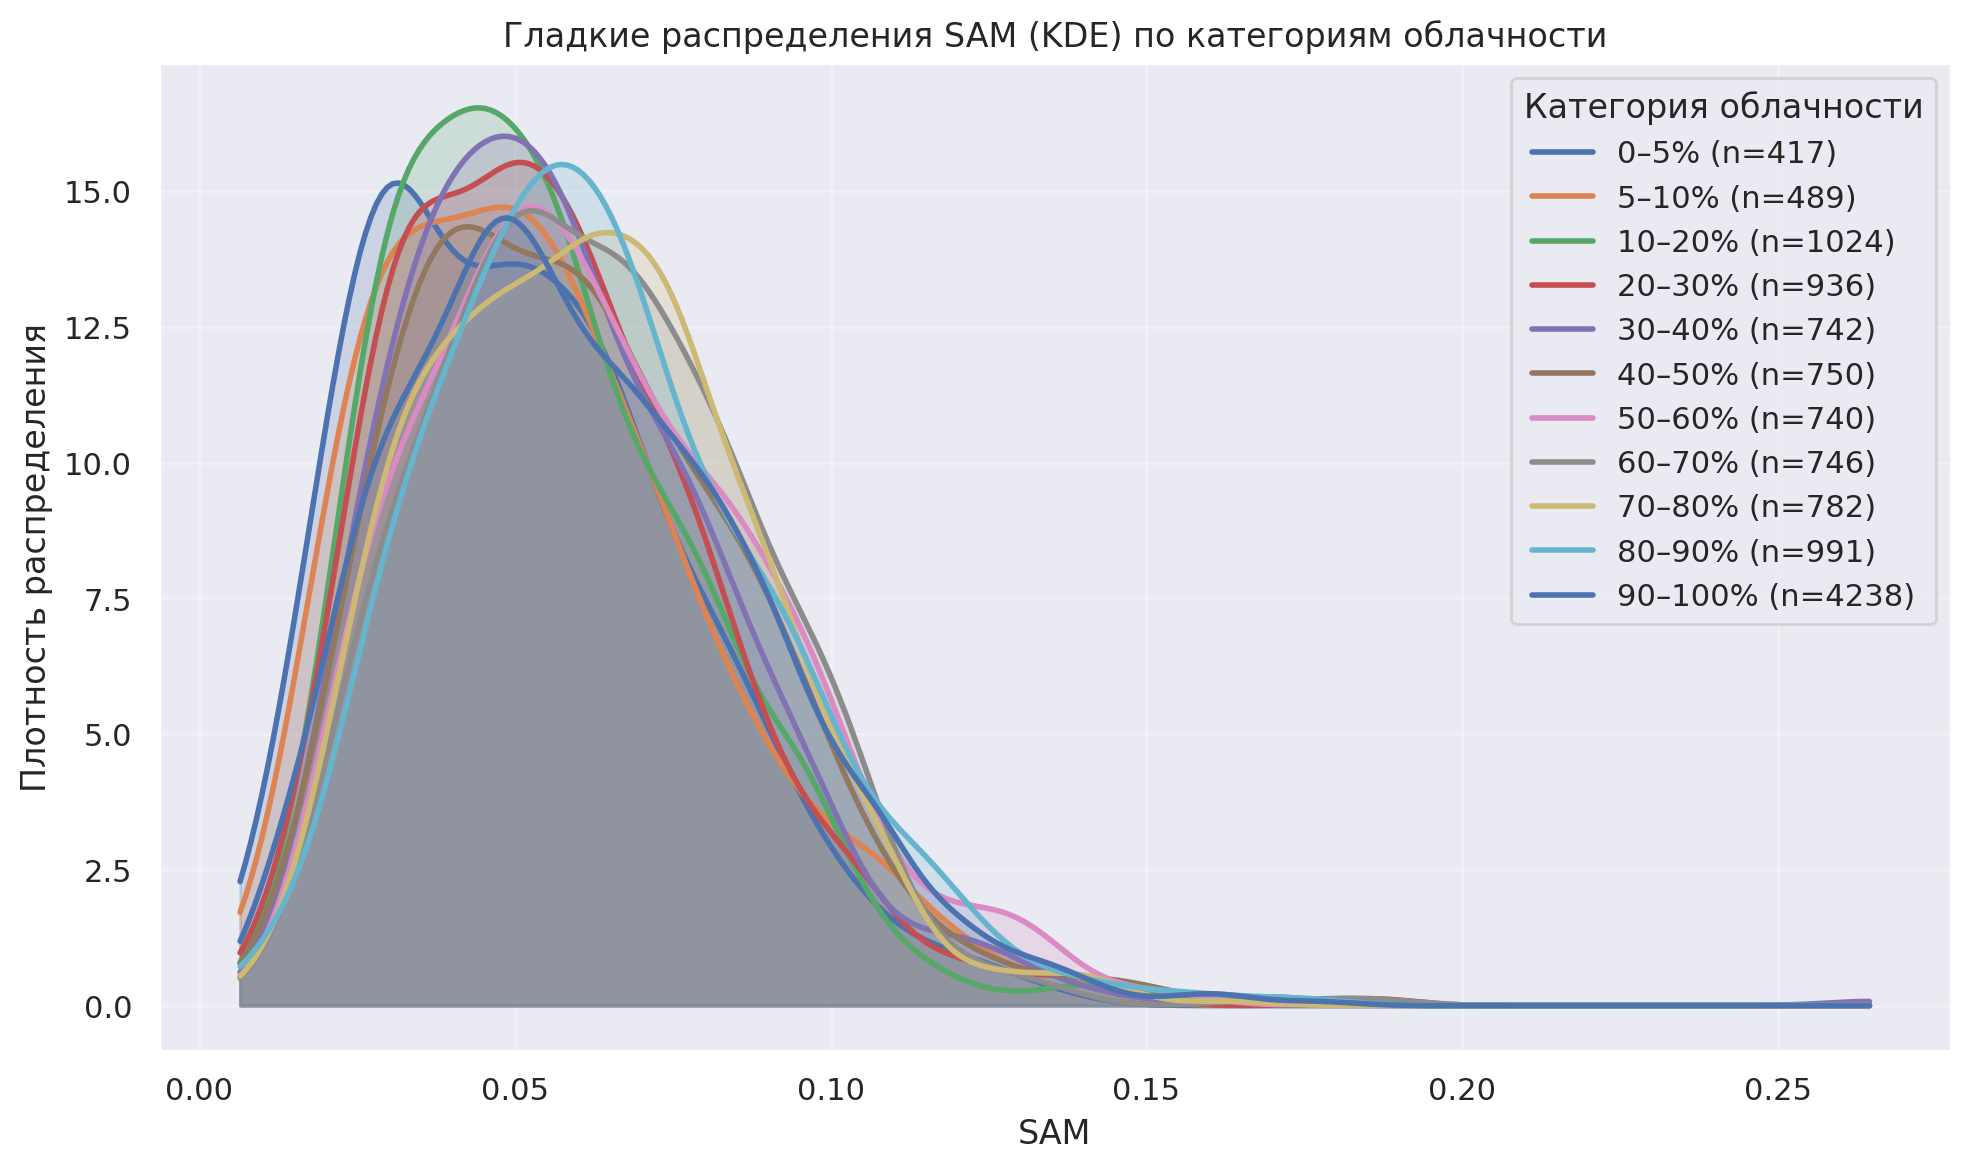

In [56]:
plot_sam_kde_by_bin(bin_stat)

In [30]:
sam_above_50 = []

for (start, end), scene_list in bin_stat.items():
    # Проверяем, что это бины с началом >= 50
    # (или строго >50, тогда if start > 50:)
    if start < 50:
        # Добавляем SAM всех сцен в общий список
        for info_dict in scene_list:
            if 'SAM' in info_dict:
                sam_above_50.append(info_dict['SAM'])

In [31]:
import numpy as np

sam_array = np.array(sam_above_50)
if len(sam_array) == 0:
    print("Нет сцен с облачностью > 50%!")
else:
    sorted_sam = np.sort(sam_array)

    count_leq_010 = np.sum(sorted_sam <= 0.10)
    total_count = len(sorted_sam)

    percentile = (count_leq_010 / total_count) * 100.0

    print(f"Среди сцен с облачностью <50%, SAM=0.10 примерно соответствует {percentile:.2f}-му перцентилю.")

Среди сцен с облачностью <50%, SAM=0.10 примерно соответствует 94.47-му перцентилю.


In [32]:
def get_sam_arrays_by_bin(bin_stat):
    """
    Возвращает dict, где ключ = (start,end),
    значение = список SAM (list of float).
    """
    sam_by_bin = {}
    for bkey, items in bin_stat.items():
        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        sam_by_bin[bkey] = sam_vals
    return sam_by_bin


In [33]:
from scipy.stats import mannwhitneyu

def compare_bins_mannwhitney(sam_by_bin, alpha=0.05):
    """
    Для каждой пары бинов (b1,b2) запускает U-тест Манна-Уитни.
    Возвращает список (b1, b2, p-value, вывод), 
    где "вывод" = "different" или "same" при выбранном alpha.
    """
    bin_keys = sorted(sam_by_bin.keys(), key=lambda x: x[0])  # сортируем по старту
    results = []
    
    for i in range(len(bin_keys)):
        for j in range(i+1, len(bin_keys)):
            b1 = bin_keys[i]
            b2 = bin_keys[j]
            sam1 = sam_by_bin[b1]
            sam2 = sam_by_bin[b2]
            
            if len(sam1) < 2 or len(sam2) < 2:
                results.append((b1, b2, None, f"not enough data"))
                continue
            
            stat, p_val = mannwhitneyu(sam1, sam2, alternative='two-sided')
            conclusion = "different" if (p_val < alpha) else "same"
            
            results.append((b1, b2, p_val, conclusion))
    
    return results

In [34]:
sam_by_bin = get_sam_arrays_by_bin(bin_stat)

mw_results = compare_bins_mannwhitney(sam_by_bin, alpha=0.05)

for (b1, b2, p_val, concl) in mw_results:
    if p_val is None:
        print(f"Bins {b1} vs {b2} => {concl}")
    else:
        print(f"Bins {b1} vs {b2} => p={p_val:.5f}, {concl}")

Bins (0, 5) vs (5, 10) => p=0.19699, same
Bins (0, 5) vs (10, 20) => p=0.04435, different
Bins (0, 5) vs (20, 30) => p=0.00425, different
Bins (0, 5) vs (30, 40) => p=0.00008, different
Bins (0, 5) vs (40, 50) => p=0.00000, different
Bins (0, 5) vs (50, 60) => p=0.00000, different
Bins (0, 5) vs (60, 70) => p=0.00000, different
Bins (0, 5) vs (70, 80) => p=0.00000, different
Bins (0, 5) vs (80, 90) => p=0.00000, different
Bins (0, 5) vs (90, 100) => p=0.00000, different
Bins (5, 10) vs (10, 20) => p=0.60251, same
Bins (5, 10) vs (20, 30) => p=0.14388, same
Bins (5, 10) vs (30, 40) => p=0.00792, different
Bins (5, 10) vs (40, 50) => p=0.00015, different
Bins (5, 10) vs (50, 60) => p=0.00000, different
Bins (5, 10) vs (60, 70) => p=0.00000, different
Bins (5, 10) vs (70, 80) => p=0.00000, different
Bins (5, 10) vs (80, 90) => p=0.00000, different
Bins (5, 10) vs (90, 100) => p=0.00000, different
Bins (10, 20) vs (20, 30) => p=0.20870, same
Bins (10, 20) vs (30, 40) => p=0.00554, differen

In [35]:
import math

def compare_bins_mannwhitney_with_bonferroni(sam_by_bin, alpha=0.05):
    bin_keys = sorted(sam_by_bin.keys(), key=lambda x: x[0])
    results = []
    
    # Сколько пар?
    # Для N бинов количество пар = N*(N-1)/2
    n = len(bin_keys)
    num_tests = n*(n-1)//2
    # "Скорректированный" alpha
    alpha_corrected = alpha / num_tests
    
    for i in range(n):
        for j in range(i+1, n):
            b1 = bin_keys[i]
            b2 = bin_keys[j]
            sam1 = sam_by_bin[b1]
            sam2 = sam_by_bin[b2]
            
            if len(sam1) < 2 or len(sam2) < 2:
                results.append((b1, b2, None, f"not enough data"))
                continue
            
            stat, p_val = mannwhitneyu(sam1, sam2, alternative='two-sided')
            # Сравниваем c alpha_corrected
            conclusion = "different" if (p_val < alpha_corrected) else "same"
            
            results.append((b1, b2, p_val, conclusion))
    
    return results

In [36]:
sam_by_bin = get_sam_arrays_by_bin(bin_stat)

mw_results = compare_bins_mannwhitney_with_bonferroni(sam_by_bin, alpha=0.05)

In [38]:
from scipy.stats import mannwhitneyu
import math
import pandas as pd

def get_sam_arrays_by_bin(bin_stat):
    sam_by_bin = {}
    for bkey, items in bin_stat.items():
        sam_vals = [it['SAM'] for it in items if 'SAM' in it]
        sam_by_bin[bkey] = sam_vals
    return sam_by_bin

def compare_bins_mannwhitney_with_bonferroni(sam_by_bin, alpha=0.05):
    bin_keys = sorted(sam_by_bin.keys(), key=lambda x: x[0])
    results = []
    
    n = len(bin_keys)
    num_tests = n * (n - 1) // 2
    alpha_corrected = alpha / num_tests if num_tests > 0 else alpha
    
    for i in range(n):
        for j in range(i+1, n):
            b1 = bin_keys[i]
            b2 = bin_keys[j]
            sam1 = sam_by_bin[b1]
            sam2 = sam_by_bin[b2]
            
            if len(sam1) < 2 or len(sam2) < 2:
                results.append((b1, b2, None, "not enough data"))
                continue
            
            stat, p_val = mannwhitneyu(sam1, sam2, alternative='two-sided')
            conclusion = "different" if (p_val < alpha_corrected) else "same"
            
            results.append((b1, b2, p_val, conclusion))
    
    return results

def print_mannwhitney_results(bin_stat, alpha=0.05):
    sam_by_bin = get_sam_arrays_by_bin(bin_stat)
    mw_results = compare_bins_mannwhitney_with_bonferroni(sam_by_bin, alpha)
    
    results_list = []
    for (b1, b2, p_val, conclusion) in mw_results:
        if p_val is not None:
            results_list.append({
                'Bin 1': f"{b1[0]}–{b1[1]}%",
                'Bin 2': f"{b2[0]}–{b2[1]}%",
                'p-value': p_val,
                'Conclusion': conclusion
            })
        else:
            results_list.append({
                'Bin 1': f"{b1[0]}–{b1[1]}%",
                'Bin 2': f"{b2[0]}–{b2[1]}%",
                'p-value': None,
                'Conclusion': conclusion
            })
    
    df_results = pd.DataFrame(results_list)
    
    print(df_results)

print_mannwhitney_results(bin_stat, alpha=0.05)

     Bin 1    Bin 2       p-value Conclusion
0     0–5%    5–10%  1.969947e-01       same
1     0–5%   10–20%  4.435190e-02       same
2     0–5%   20–30%  4.253065e-03       same
3     0–5%   30–40%  8.244217e-05  different
4     0–5%   40–50%  5.174604e-07  different
5     0–5%   50–60%  1.608294e-11  different
6     0–5%   60–70%  7.455559e-13  different
7     0–5%   70–80%  1.674160e-11  different
8     0–5%   80–90%  1.211171e-14  different
9     0–5%  90–100%  1.869543e-09  different
10   5–10%   10–20%  6.025059e-01       same
11   5–10%   20–30%  1.438801e-01       same
12   5–10%   30–40%  7.919293e-03       same
13   5–10%   40–50%  1.456150e-04  different
14   5–10%   50–60%  1.412980e-08  different
15   5–10%   60–70%  1.194941e-09  different
16   5–10%   70–80%  1.574053e-08  different
17   5–10%   80–90%  2.030834e-11  different
18   5–10%  90–100%  2.205386e-06  different
19  10–20%   20–30%  2.086971e-01       same
20  10–20%   30–40%  5.539183e-03       same
21  10–20%

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_pvalue_matrix(mw_results):
    """
    Формирует матрицу p-values (DataFrame) размера N x N,
    где N — число бинов. 
    mw_results = список кортежей (b1, b2, p_val, conclusion).
    """
    bins_set = set()
    for b1, b2, p_val, concl in mw_results:
        bins_set.add(b1)
        bins_set.add(b2)
    bin_keys = sorted(bins_set, key=lambda x: x[0])
    bin_index = {bk: i for i, bk in enumerate(bin_keys)}
    N = len(bin_keys)
    
    pvals = np.full((N, N), np.nan)
    
    for b1, b2, p_val, concl in mw_results:
        if p_val is not None:
            i = bin_index[b1]
            j = bin_index[b2]
            pvals[i, j] = p_val
            pvals[j, i] = p_val
        else:
            pass
    
    df = pd.DataFrame(pvals, index=bin_keys, columns=bin_keys)
    return df

df_pvals = create_pvalue_matrix(mw_results)
df_pvals

def create_diff_matrix(mw_results):
    bins_set = set()
    for b1, b2, p_val, concl in mw_results:
        bins_set.add(b1)
        bins_set.add(b2)
    bin_keys = sorted(bins_set, key=lambda x: x[0])
    bin_index = {bk: i for i, bk in enumerate(bin_keys)}
    N = len(bin_keys)
    
    mat = np.full((N, N), np.nan)
    for b1, b2, p_val, concl in mw_results:
        i = bin_index[b1]
        j = bin_index[b2]
        if concl == "different":
            mat[i, j] = 1
            mat[j, i] = 1
        elif concl == "same":
            mat[i, j] = 0
            mat[j, i] = 0
        else:

            pass
    
    df_diff = pd.DataFrame(mat, index=bin_keys, columns=bin_keys)
    return df_diff

df_diff = create_diff_matrix(mw_results)

plt.figure(figsize=(8,6))
sns.heatmap(df_diff, annot=True, cmap="Reds", center=0.5, 
            square=True, cbar=False)
plt.title("Mann-Whitney conclusion: 1=different, 0=same, NaN=not enough data")
plt.xlabel("Bin")
plt.ylabel("Bin")
plt.show()